# SAES for Multiobjective Optimization algorithms Benchmarking

# MRI Scan Segmentation – Experimental Results

This notebook presents the evaluation results of multiple models trained for MRI scan segmentation. We conducted extensive experiments using ten different models based on two main architectures: **nnUNet** and **YOLO**, applied across 2D and 3D settings.

## Objective

The goal is to compare the segmentation performance of different architectures and training configurations, taking into account not only accuracy metrics but also resource usage (GPU, CPU, memory) during training and inference.

## Experimental Setup

For each of the models listed below, we conducted the following experiment:

- We divided the dataset into 5 parts to perform **k-fold cross-validation** with \( k = 5 \).
- For **each fold**, we trained **every model 30 times** and evaluated the results.

Why did we do this?

> To ensure that the **statistical tests** we perform later have **statistical significance**.  
> In other words, we wanted to reduce the impact of randomness and provide a more reliable comparison.

Given that we have **10 models**, the total number of trainings was:

- $10 \text{ models} \times 5 \text{ folds} \times 30 \text{ repetitions} = \textbf{1500 models trained}$
  - Of these, **300 are nnUNet**
  - And **1200 are YOLO**

### **nnUNet Models**
- `nnUNet2d`: A 2D version of the nnUNet architecture, trained and validated using 2D slices of the MRI dataset.
- `nnUNet3d`: A 3D version of the nnUNet architecture, trained and validated using full volumetric data.

### **YOLO Models**
The YOLO-based models differ primarily in the way the dataset is sliced and used for training/validation. We evaluated the following:

#### YOLO3D (Trained using 3D volumes sliced in different planes):
- `yolo3d_consensus`: Trained using all three planes (axial, coronal, sagittal); validation uses a 2-out-of-3 consensus.
- `yolo3d_axial`: Trained and validated using only axial plane slices.
- `yolo3d_coronal`: Trained and validated using only coronal plane slices.
- `yolo3d_sagittal`: Trained and validated using only sagittal plane slices.

#### YOLO2D (Trained using individual planes):
- `yolo2d_consensus`: Combines one model trained on each plane; validation uses a 2-out-of-3 consensus strategy.
- `yolo2d_axial`: Trained and validated using only the axial plane.
- `yolo2d_coronal`: Trained and validated using only the coronal plane.
- `yolo2d_sagittal`: Trained and validated using only the sagittal plane.

## Resource Monitoring

We also include GPU, CPU, and memory usage graphs captured from the **Picasso system** during the training processes of both `nnUNet2d` and `nnUNet3d`. These graphs help assess the computational efficiency and hardware demands of each model configuration.

Below is the resource consumption of a single training process for `nnUNet2D`:


![Alt text](2d.jpg)


And here is the consumption for `nnUNet3D`. As we can see, the resource usage is significantly higher. As we will show later, although the results are better, the improvement is not substantial enough to justify this large increase in resource usage.


![Alt text](3d.jpg)


Finally, the training of the YOLO models shows a resource consumption comparable to `nnUNet3D`, but as we will see, their performance is significantly poorer in comparison.


## Load the Data

We have three CSV files containing results: one with only the YOLO model results, one with the nnUNet results, and one with the combined results. This separation is necessary because, as we will see later, the results differ significantly and need to be visualized separately.

In [136]:
from SAES.latex_generation.stats_table import Friedman, Wilcoxon, WilcoxonPivot
from SAES.plots.boxplot import Boxplot
from SAES.plots.CDplot import CDplot
from SAES.plots.violin import Violin
from SAES.plots.HistoPlot import HistoPlot
from SAES.plots.Pplot import Pplot

import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os

In [150]:
yolo_data = pd.read_csv('yolo.csv')
nnUNet_data = pd.read_csv('nnUNet.csv')
yolo_nnUNet_data = pd.read_csv('yolo_nnUNet.csv')

yolo_nnUNet_data

,Algorithm,Instance,MetricName,ExecutionId,MetricValue
0,nnUNet3D,fold1,DSC,1,0.753997
1,nnUNet3D,fold1,FN,1,3086.777778
2,nnUNet3D,fold1,FNR,1,0.237539
3,nnUNet3D,fold1,FP,1,1340.777778
4,nnUNet3D,fold1,FPR,1,0.000186
...,...,...,...,...,...
5095,Yolo2D-s,fold5,DSC,26,0.121399
5096,Yolo2D-s,fold5,DSC,27,0.123975
5097,Yolo2D-s,fold5,DSC,28,0.136433
5098,Yolo2D-s,fold5,DSC,29,0.103208


In [151]:
# Compared algoritms
algorithms = yolo_nnUNet_data.Algorithm
list(algorithms.unique())

['nnUNet3D',
 'nnUNet2D',
 'Yolo3D',
 'Yolo3D-a',
 'Yolo3D-c',
 'Yolo3D-s',
 'Yolo2D',
 'Yolo2D-a',
 'Yolo2D-c',
 'Yolo2D-s']

In [ ]:
# Load the metrics (quality indicators) data
metrics = pd.read_csv('metrics.csv')
metrics

,MetricName,Maximize
0,DSC,True
1,FN,False
2,FNR,False
3,FP,False
4,FPR,False
5,Iou,True
6,NPV,True
7,TN,True
8,TP,True
9,acc,True


### Dice Similarity Coefficient (DSC)

The **Dice Similarity Coefficient (DSC)** is a statistical metric used to measure the similarity between two sets. In the context of medical image segmentation, it is commonly used to evaluate the overlap between the **predicted segmentation** and the **ground truth**.

DSC ranges from 0 to 1:
- A DSC of **1** indicates perfect agreement (complete overlap).
- A DSC of **0** means no overlap between the predicted and ground truth regions.

$$
\text{DSC} = \frac{2 \cdot |A \cap B|}{|A| + |B|}
$$

Where:
- $A$ is the set of pixels in the **ground truth** segmentation,
- $B$ is the set of pixels in the **predicted** segmentation,
- $|A \cap B|$ is the number of overlapping pixels (true positives),
- $|A|$ and $|B|$ are the number of pixels in each respective segmentation mask.

In binary segmentation masks (where 1 = foreground, 0 = background), this is equivalent to:

$$
\text{DSC} = \frac{2 \cdot TP}{2 \cdot TP + FP + FN}
$$

Where:
- **TP** = True Positives,
- **FP** = False Positives,
- **FN** = False Negatives.

The Dice coefficient is particularly useful in medical image analysis, such as MRI segmentation, where class imbalance can be significant and it is the metric that we will use for our study.


In [140]:
metric = "DSC"

## Boxplot Graph

A **boxplot**, also known as a **box-and-whisker plot**, is a graphical tool used to summarize and visualize the distribution of a dataset. It allows you to identify key features such as central tendency, variability, and the presence of outliers, offering a simple way to interpret the data.

The **main body of the boxplot** is the box, which represents the **interquartile range (IQR)**, the range between the first quartile (**Q1**) and the third quartile (**Q3**). This area contains the middle 50% of the data. Inside the box, a line indicates the **median** (second quartile, **Q2**), the value that divides the data into two equal halves. The **whiskers** extend from the box to the smallest and largest values that are within 1.5 times the IQR from Q1 or Q3, respectively. Points outside this range are considered **outliers** and are often shown as individual points.

The **interpretation of the boxplot** depends on the context and the goal of the analysis. If the goal is to **maximize** a metric (such as profit or performance), attention should be paid to the higher values, both within the box and in the upper whiskers or outliers. On the other hand, if the goal is to **minimize** (such as errors or costs), the focus should be on the lower values. Additionally, the position of the median within the box can indicate the skewness of the data: if it is closer to Q1 or Q3, the distribution is not symmetrical.

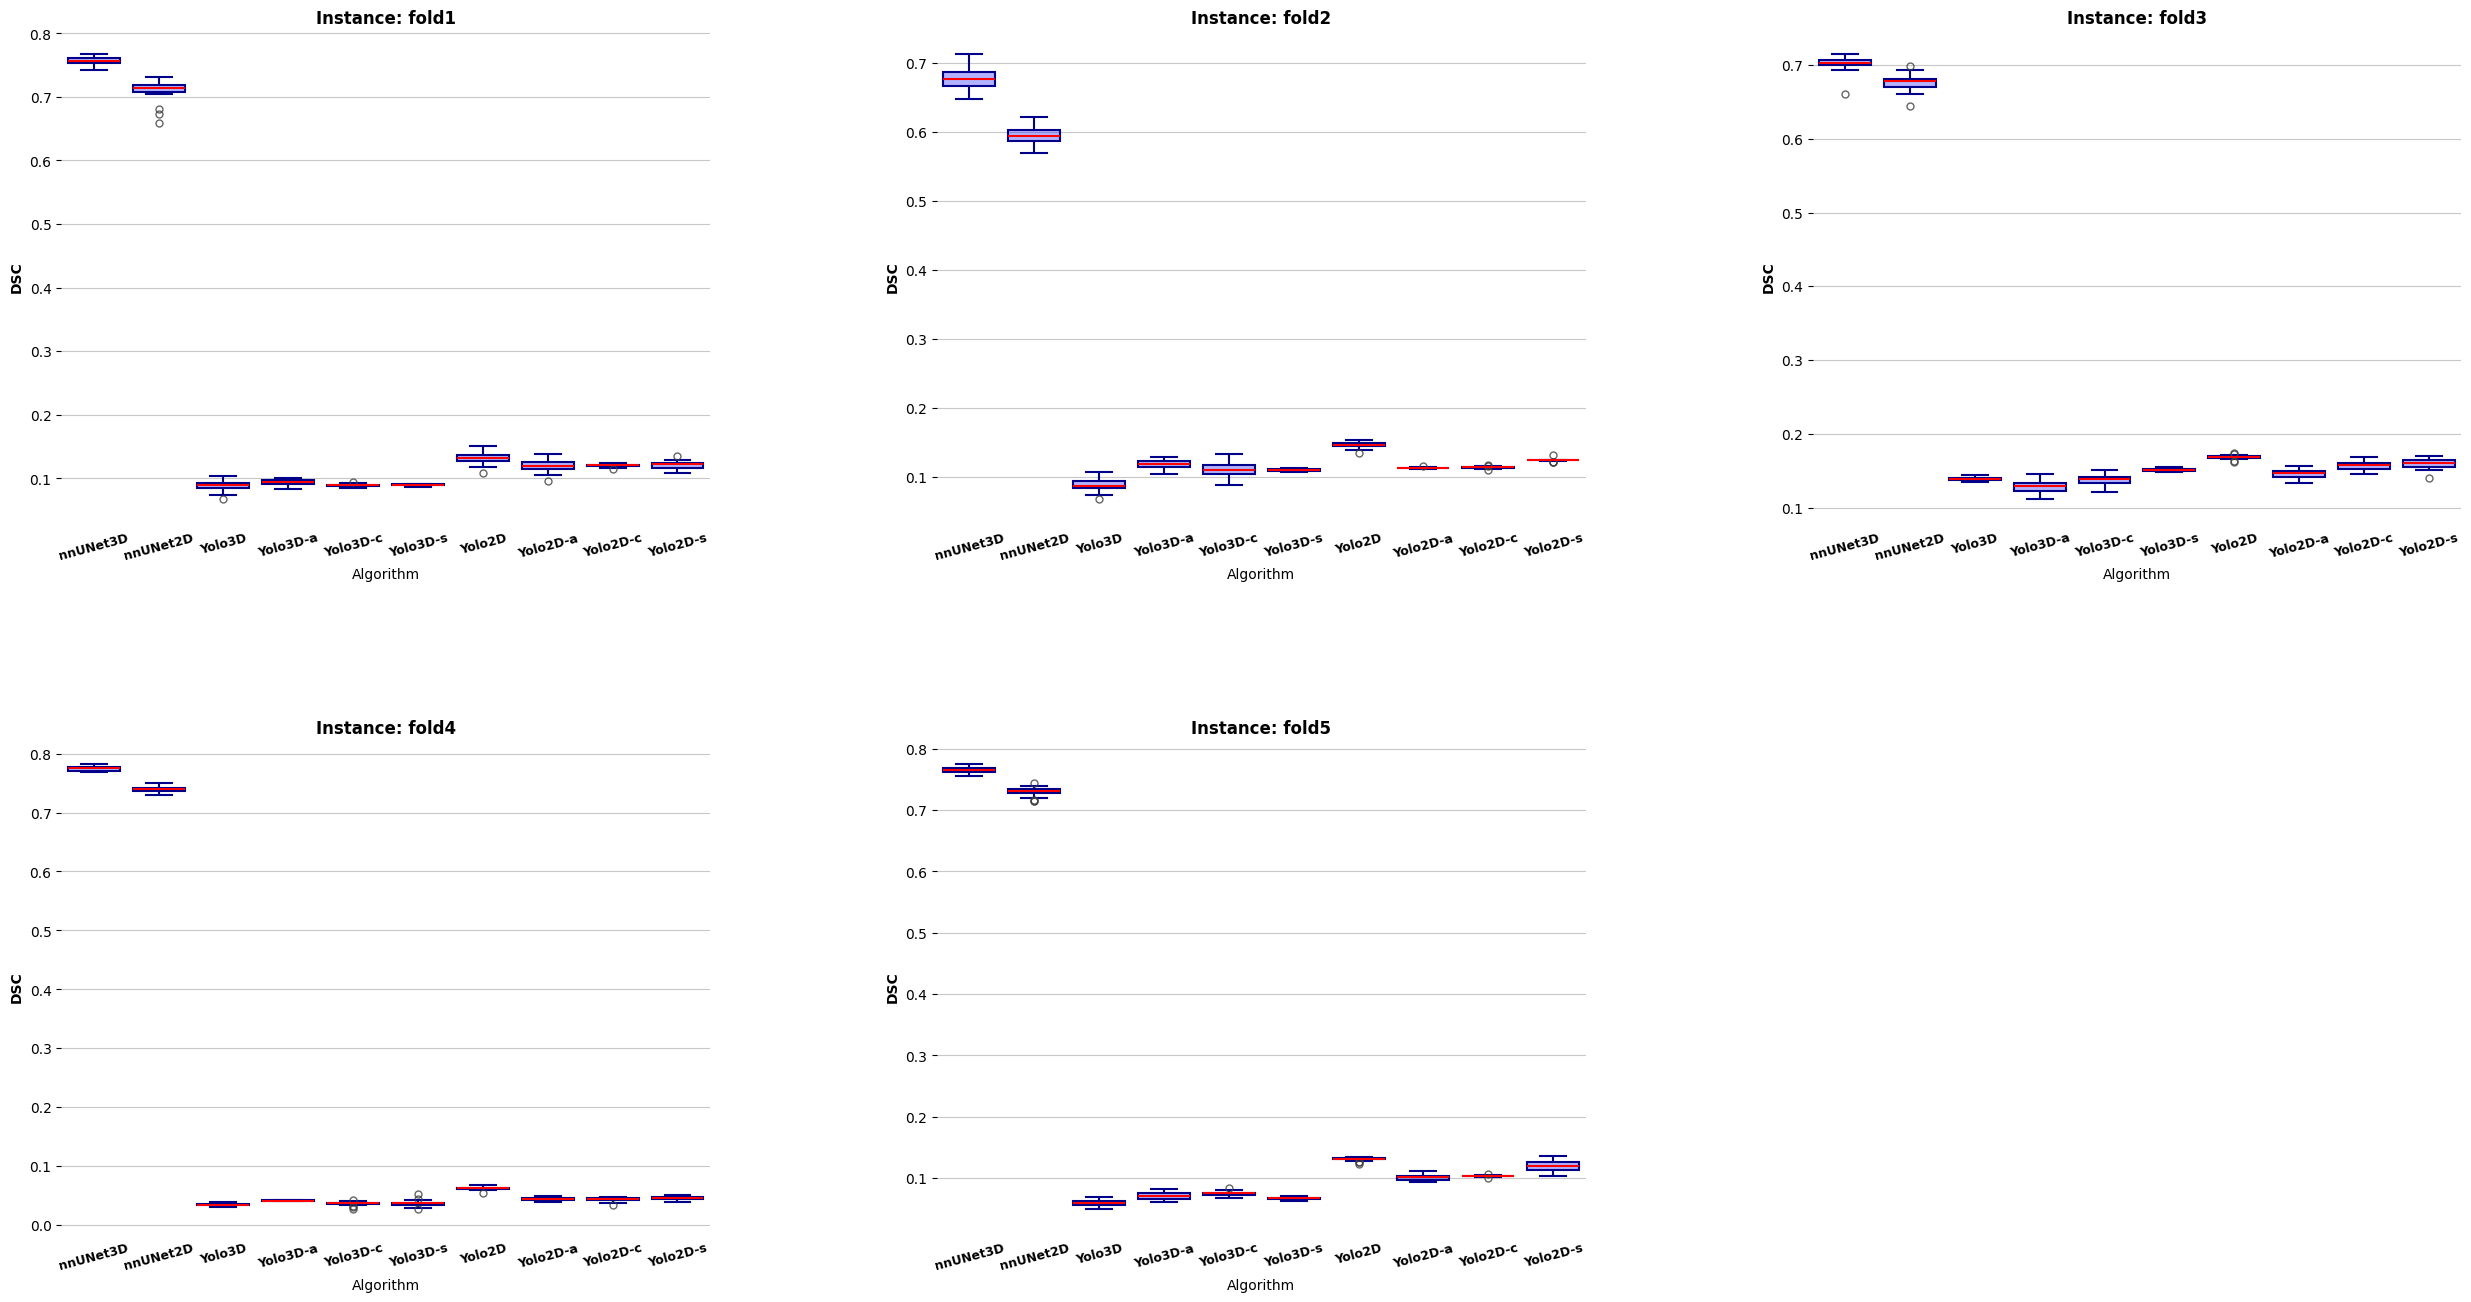

In [ ]:
boxplot = Boxplot(yolo_nnUNet_data, metrics, metric)
boxplot.show_all_instances()

From this graph, the only clear takeaway is that the nnUNet models significantly outperform the YOLO models. Therefore, we will analyze them separately.

### Boxplot YOLO

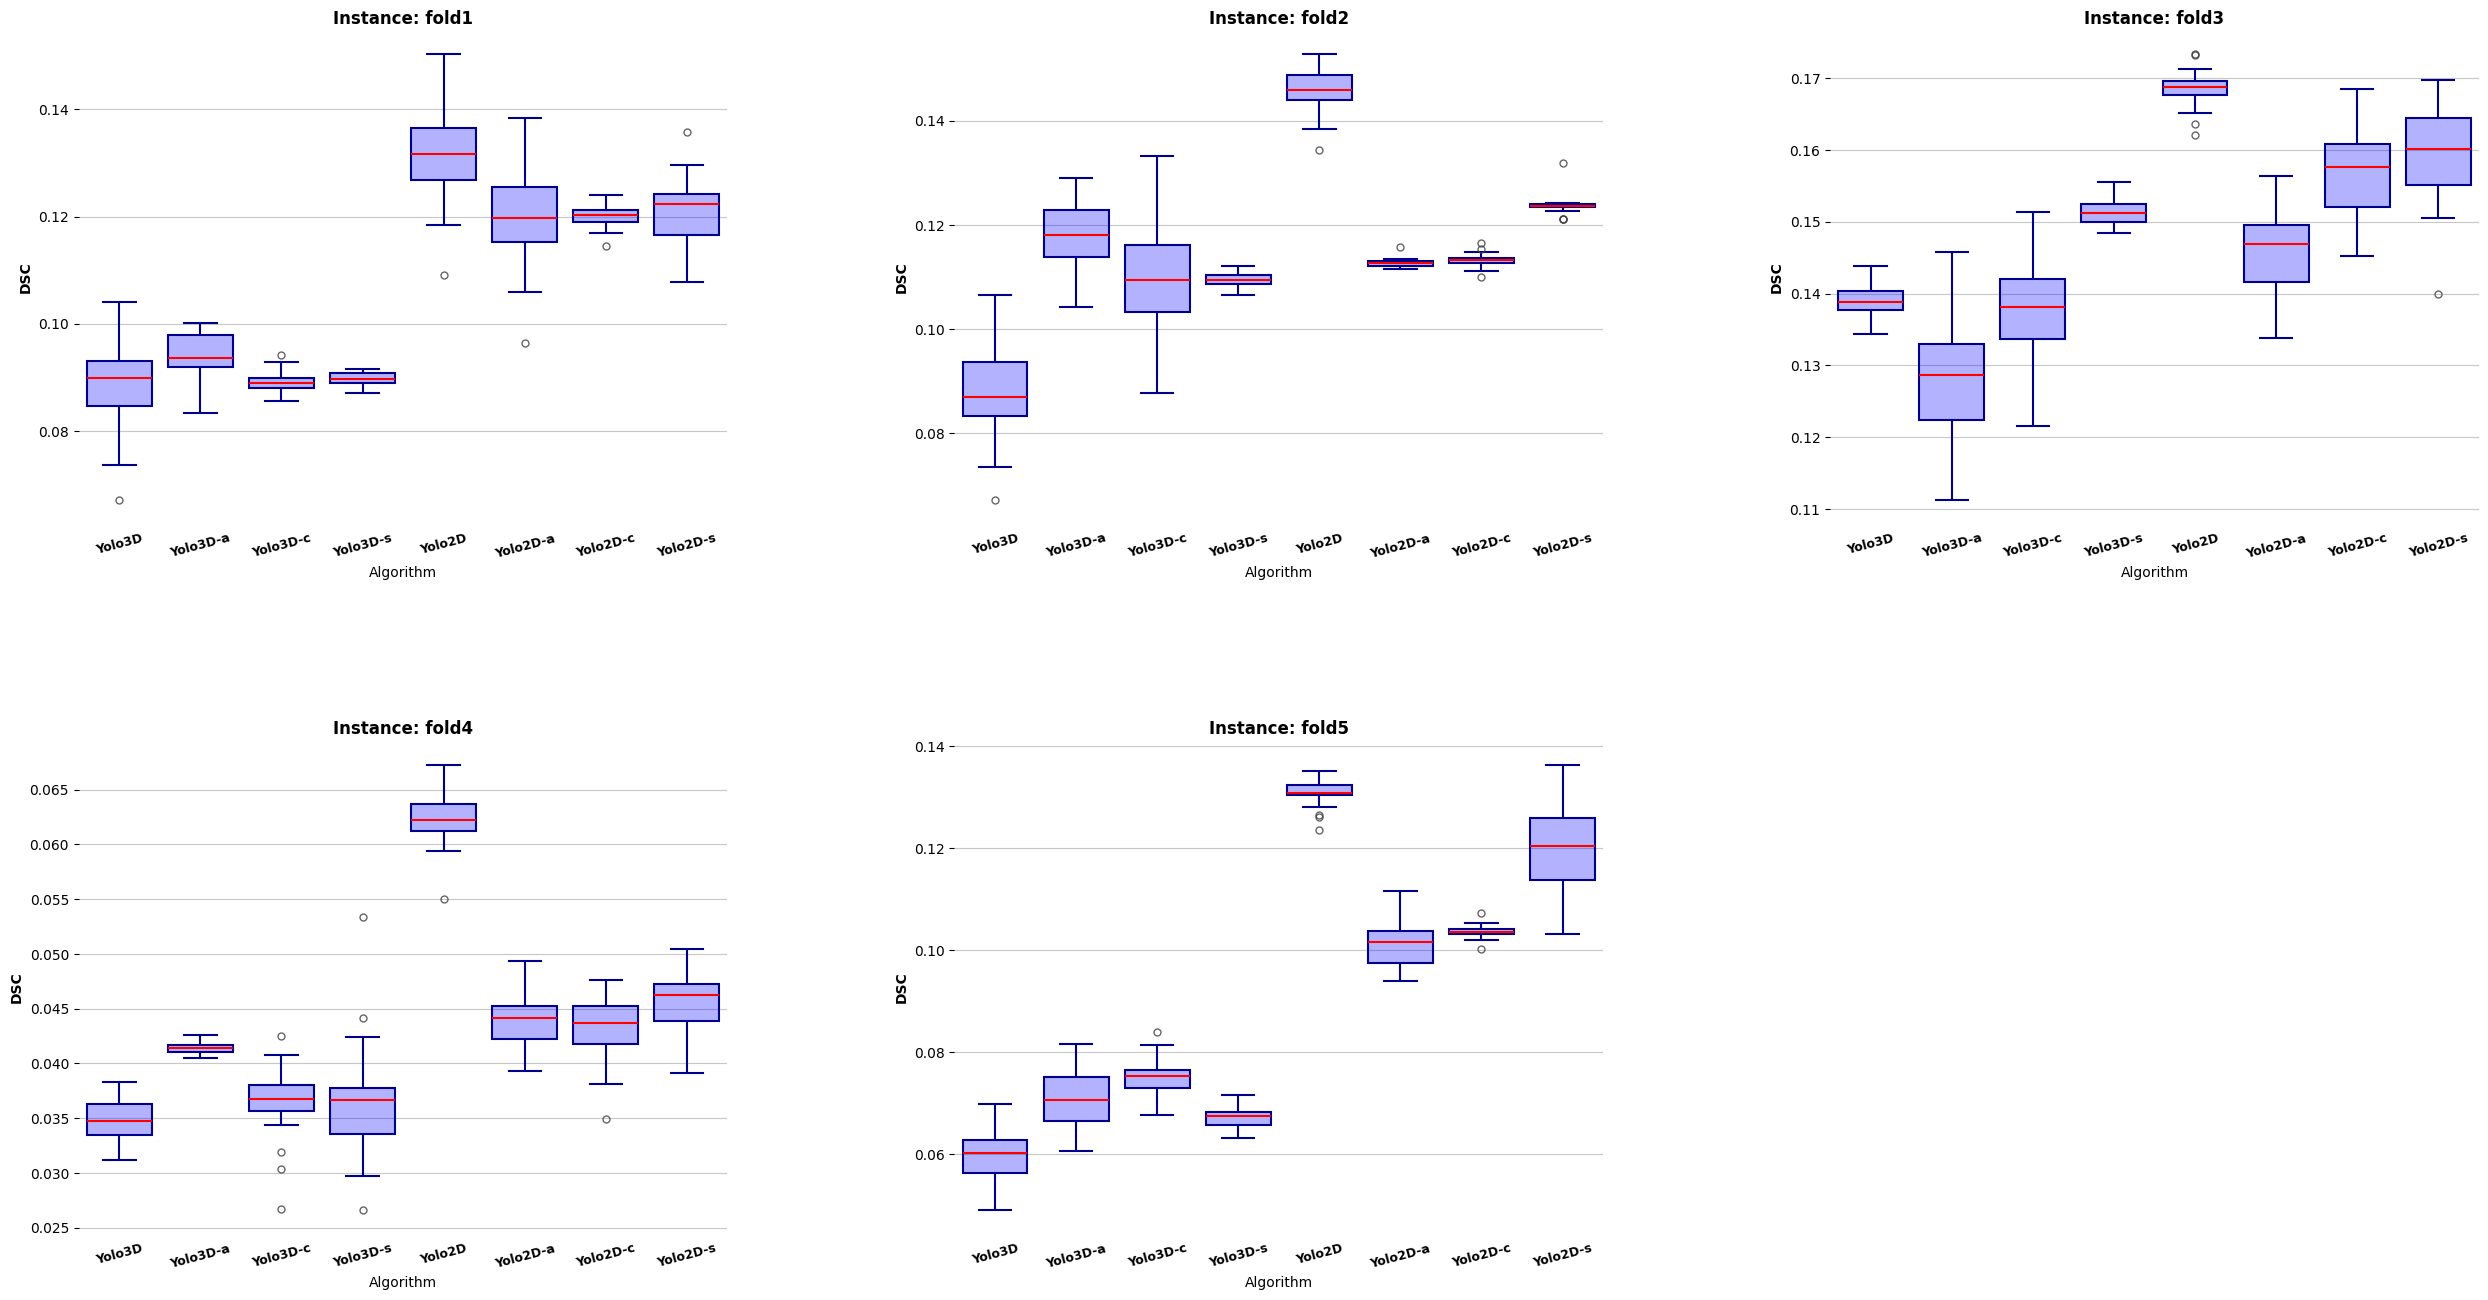

In [ ]:
boxplot = Boxplot(yolo_data, metrics, metric)
boxplot.show_all_instances()

This boxplot clearly shows a consistent winner across every fold of validation: Yolo2D, which uses a consensus approach over three models, each trained on a single anatomical plane. The conclusion we can draw is that, due to the inherently 2D nature of the YOLO architecture, its performance significantly improves when it is trained on images from only one plane at a time. Once a consensus is formed among the three specialized models, the overall performance becomes even better.

This interpretation is further supported by the fact that all the 2D models outperform any of the 3D models, according to the graph. This suggests that when using a 2D-based model architecture, attempting to learn from 3D information directly is suboptimal. Instead, the learning process should be divided across multiple models, each focusing on a specific 2D slice or view of the data.

### Boxplot nnUNet

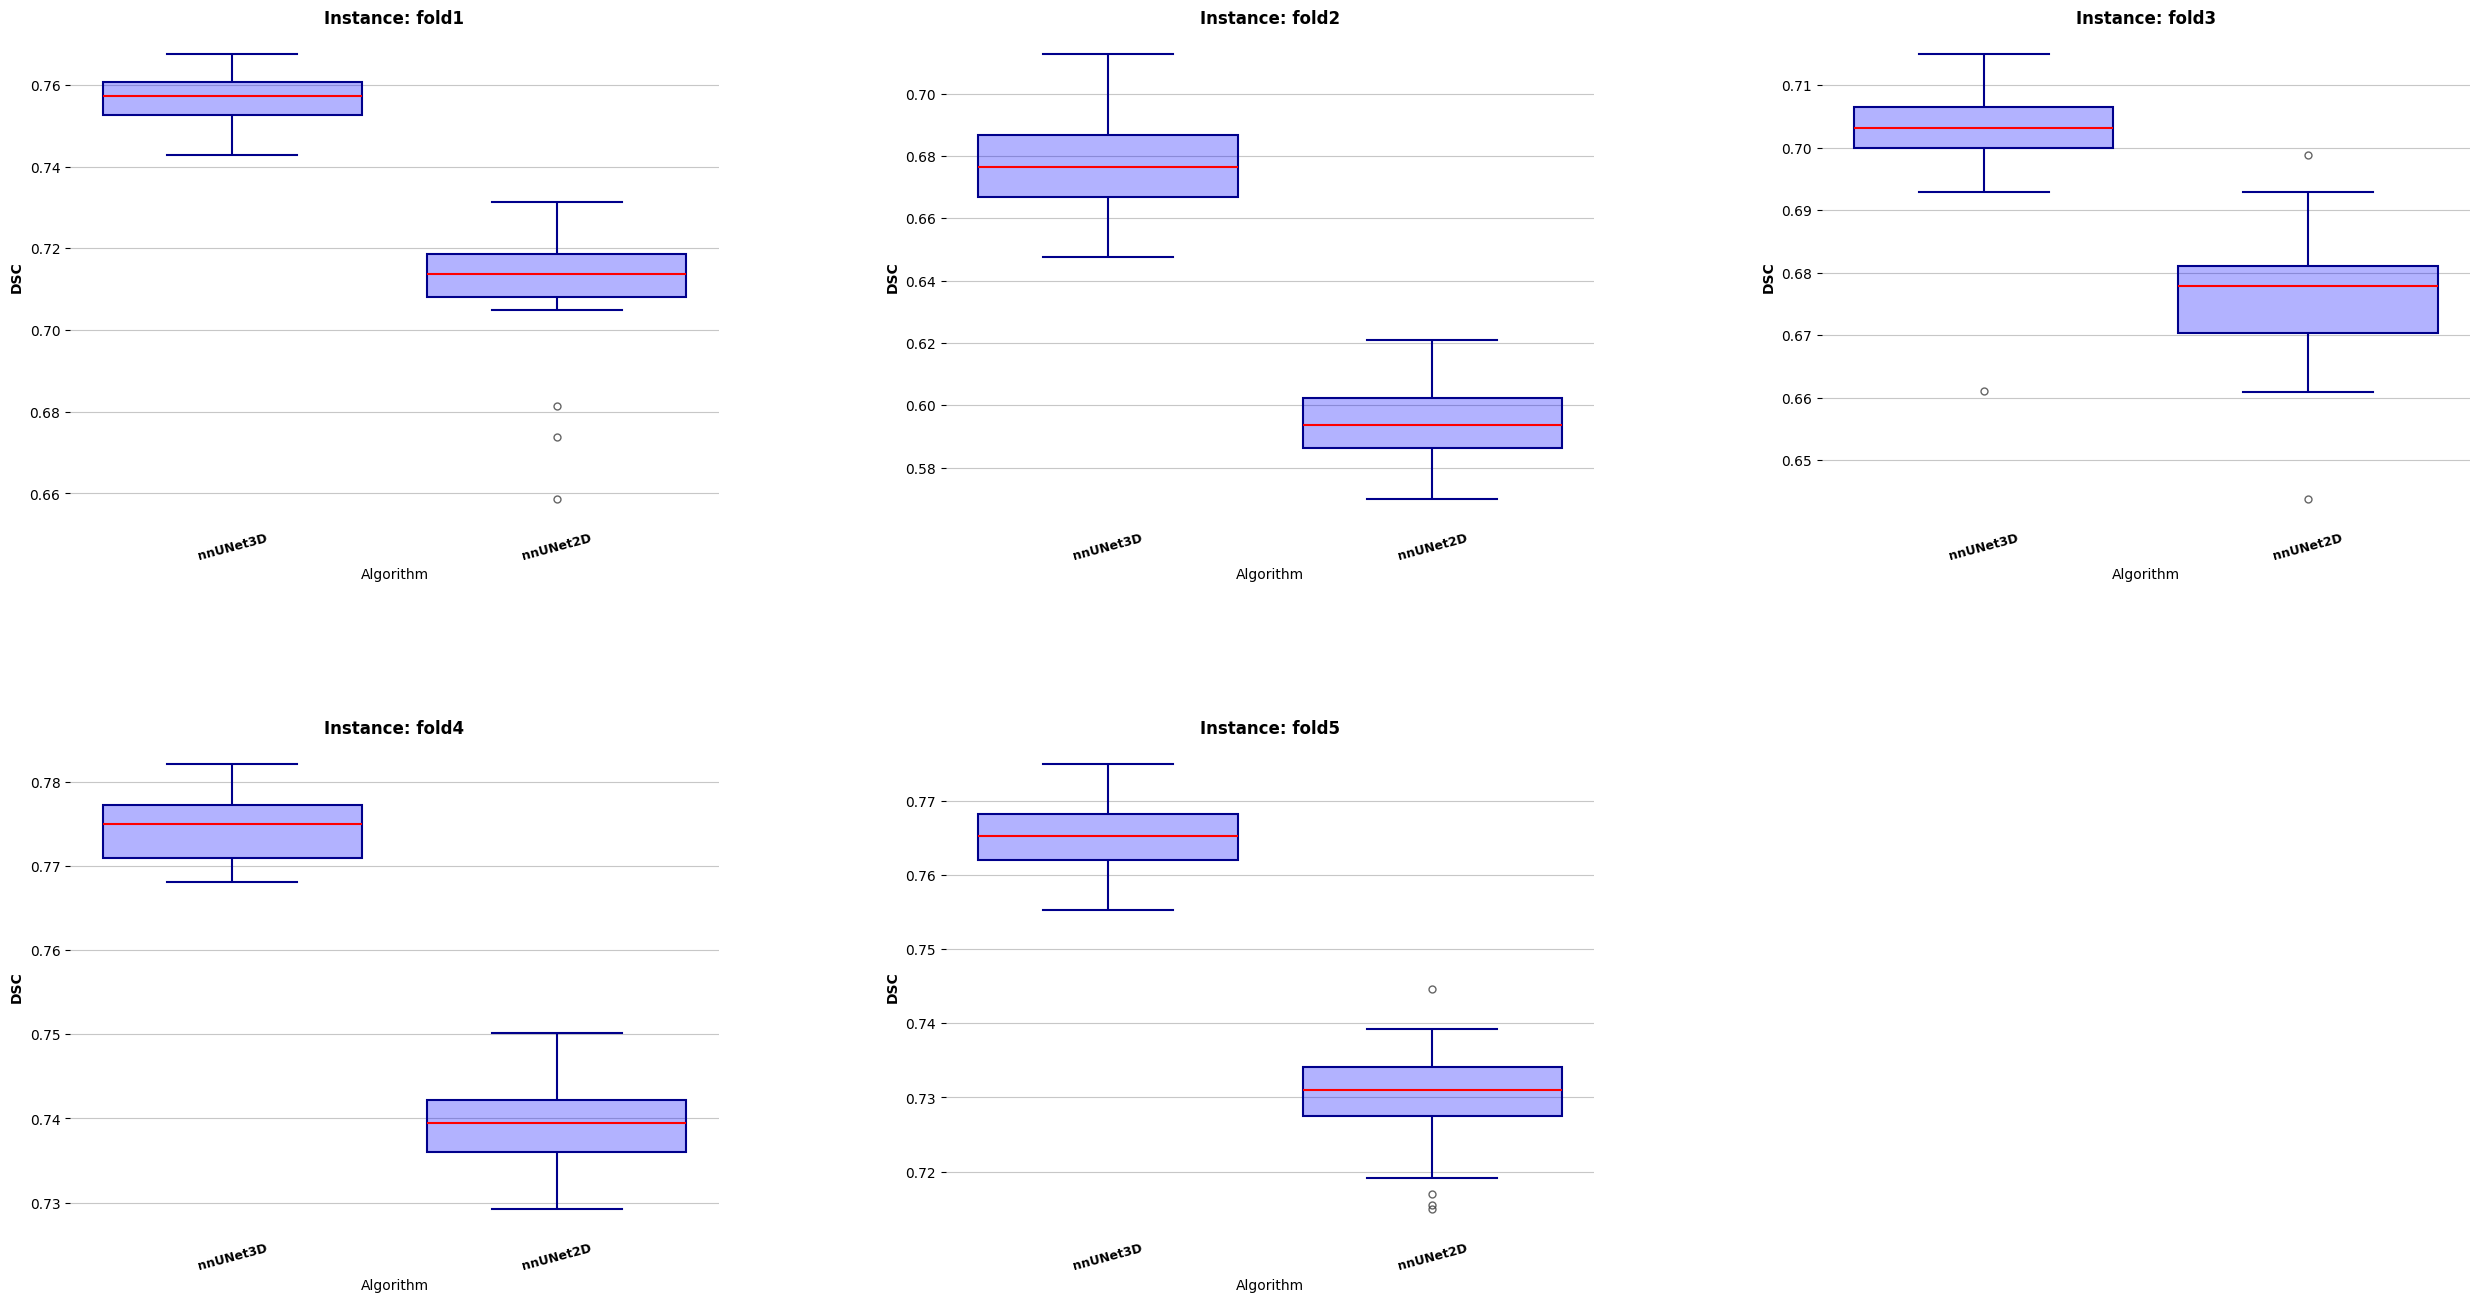

In [154]:
boxplot = Boxplot(nnUNet_data, metrics, metric)
boxplot.show_all_instances()

The results of the nnUNet models are easier to interpret. The 3D version achieves a Dice Similarity Coefficient (DSC) of around 0.76, while the 2D version scores around 0.72. This 0.06 difference can be considered significant, depending on how strict we want to be. However, if we are willing to sacrifice a bit of precision, the 2D version is a very attractive option, as its training process is approximately 10 times cheaper.

## Violin Plot

A **violin plot** is another graphical tool used to visualize the distribution of a dataset, combining aspects of both a **boxplot** and a **density plot**. It is particularly useful for understanding the distribution of data, especially when comparing multiple groups or datasets.

The **main feature of a violin plot** is its **shape**, which is formed by a **kernel density estimation (KDE)** that shows the probability distribution of the data. The plot looks like a violin because it is symmetric on both sides of a central axis, with the width at different values indicating the density of data points at that value.

Here are the key components of a violin plot:

1. **Central axis**: Like a boxplot, a violin plot has a central axis where the data is plotted. This axis typically represents the variable of interest.
   
2. **Density curve (the "violin" shape)**: The main part of the violin plot is the **density curve**, which shows how the data is distributed along the axis. Wider sections of the curve indicate higher density (more data points), while narrower sections indicate lower density (fewer data points). The shape helps to visualize the distribution more clearly than a boxplot alone, especially when there are multiple peaks (modes) in the data.

3. **Boxplot within the violin**: A **boxplot** is often included inside the violin plot, showing the **median**, **first quartile (Q1)**, and **third quartile (Q3)**. The whiskers of the boxplot often extend to the smallest and largest values within 1.5 times the IQR, and any data points outside this range are considered outliers.

4. **Individual data points (optional)**: Some violin plots also show individual data points as dots or other markers, providing an additional layer of detail.

### **Interpretation of a Violin Plot**:
- **Shape**: The overall shape of the violin gives insights into the distribution of the data. A symmetrical violin suggests a roughly normal distribution, while asymmetrical shapes can indicate skewness.
- **Peaks**: The presence of multiple peaks in the violin indicates that the data may have multiple modes, or subgroups, within it.
- **Width**: The width of the violin at various values provides a clear indication of the data's **density**—wider areas mean higher data concentration, and narrower areas mean less concentration.
- **Boxplot features**: The boxplot part of the violin allows you to see the **median**, **quartiles**, and **outliers**, giving a summary of the spread and central tendency of the data.

Violin plots are particularly useful when comparing multiple distributions side-by-side, as they provide both a summary and a detailed visualization of the data's distribution.

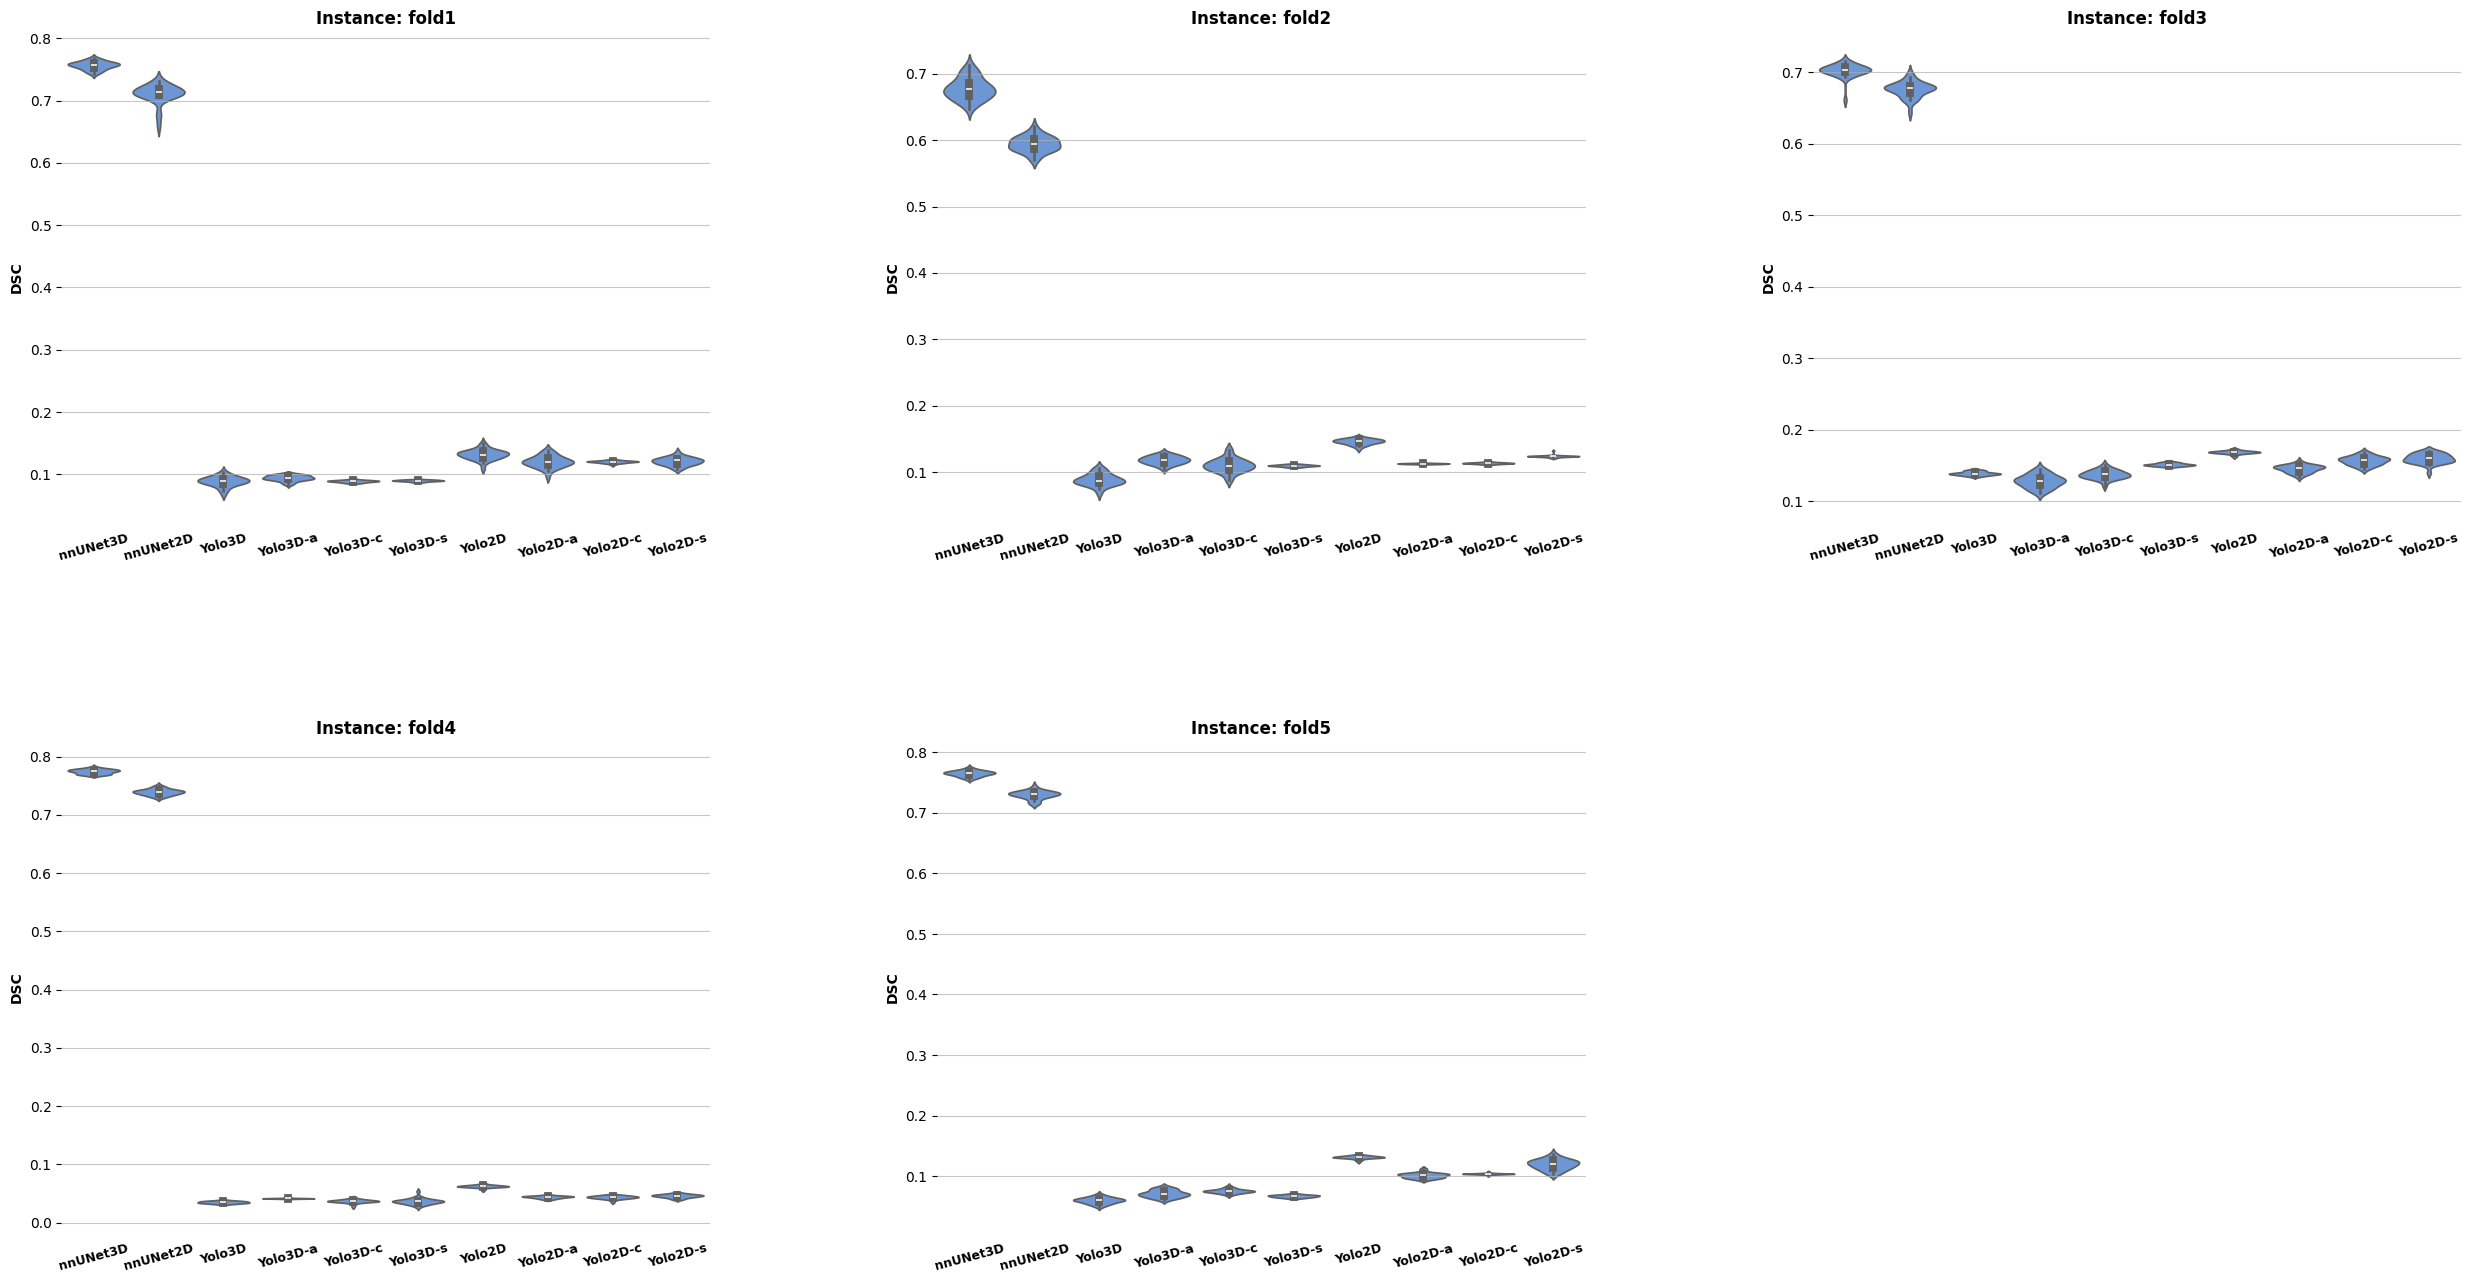

In [156]:
violin = Violin(yolo_nnUNet_data, metrics, "DSC")
violin.show_all_instances()

### Violin Plot Yolo

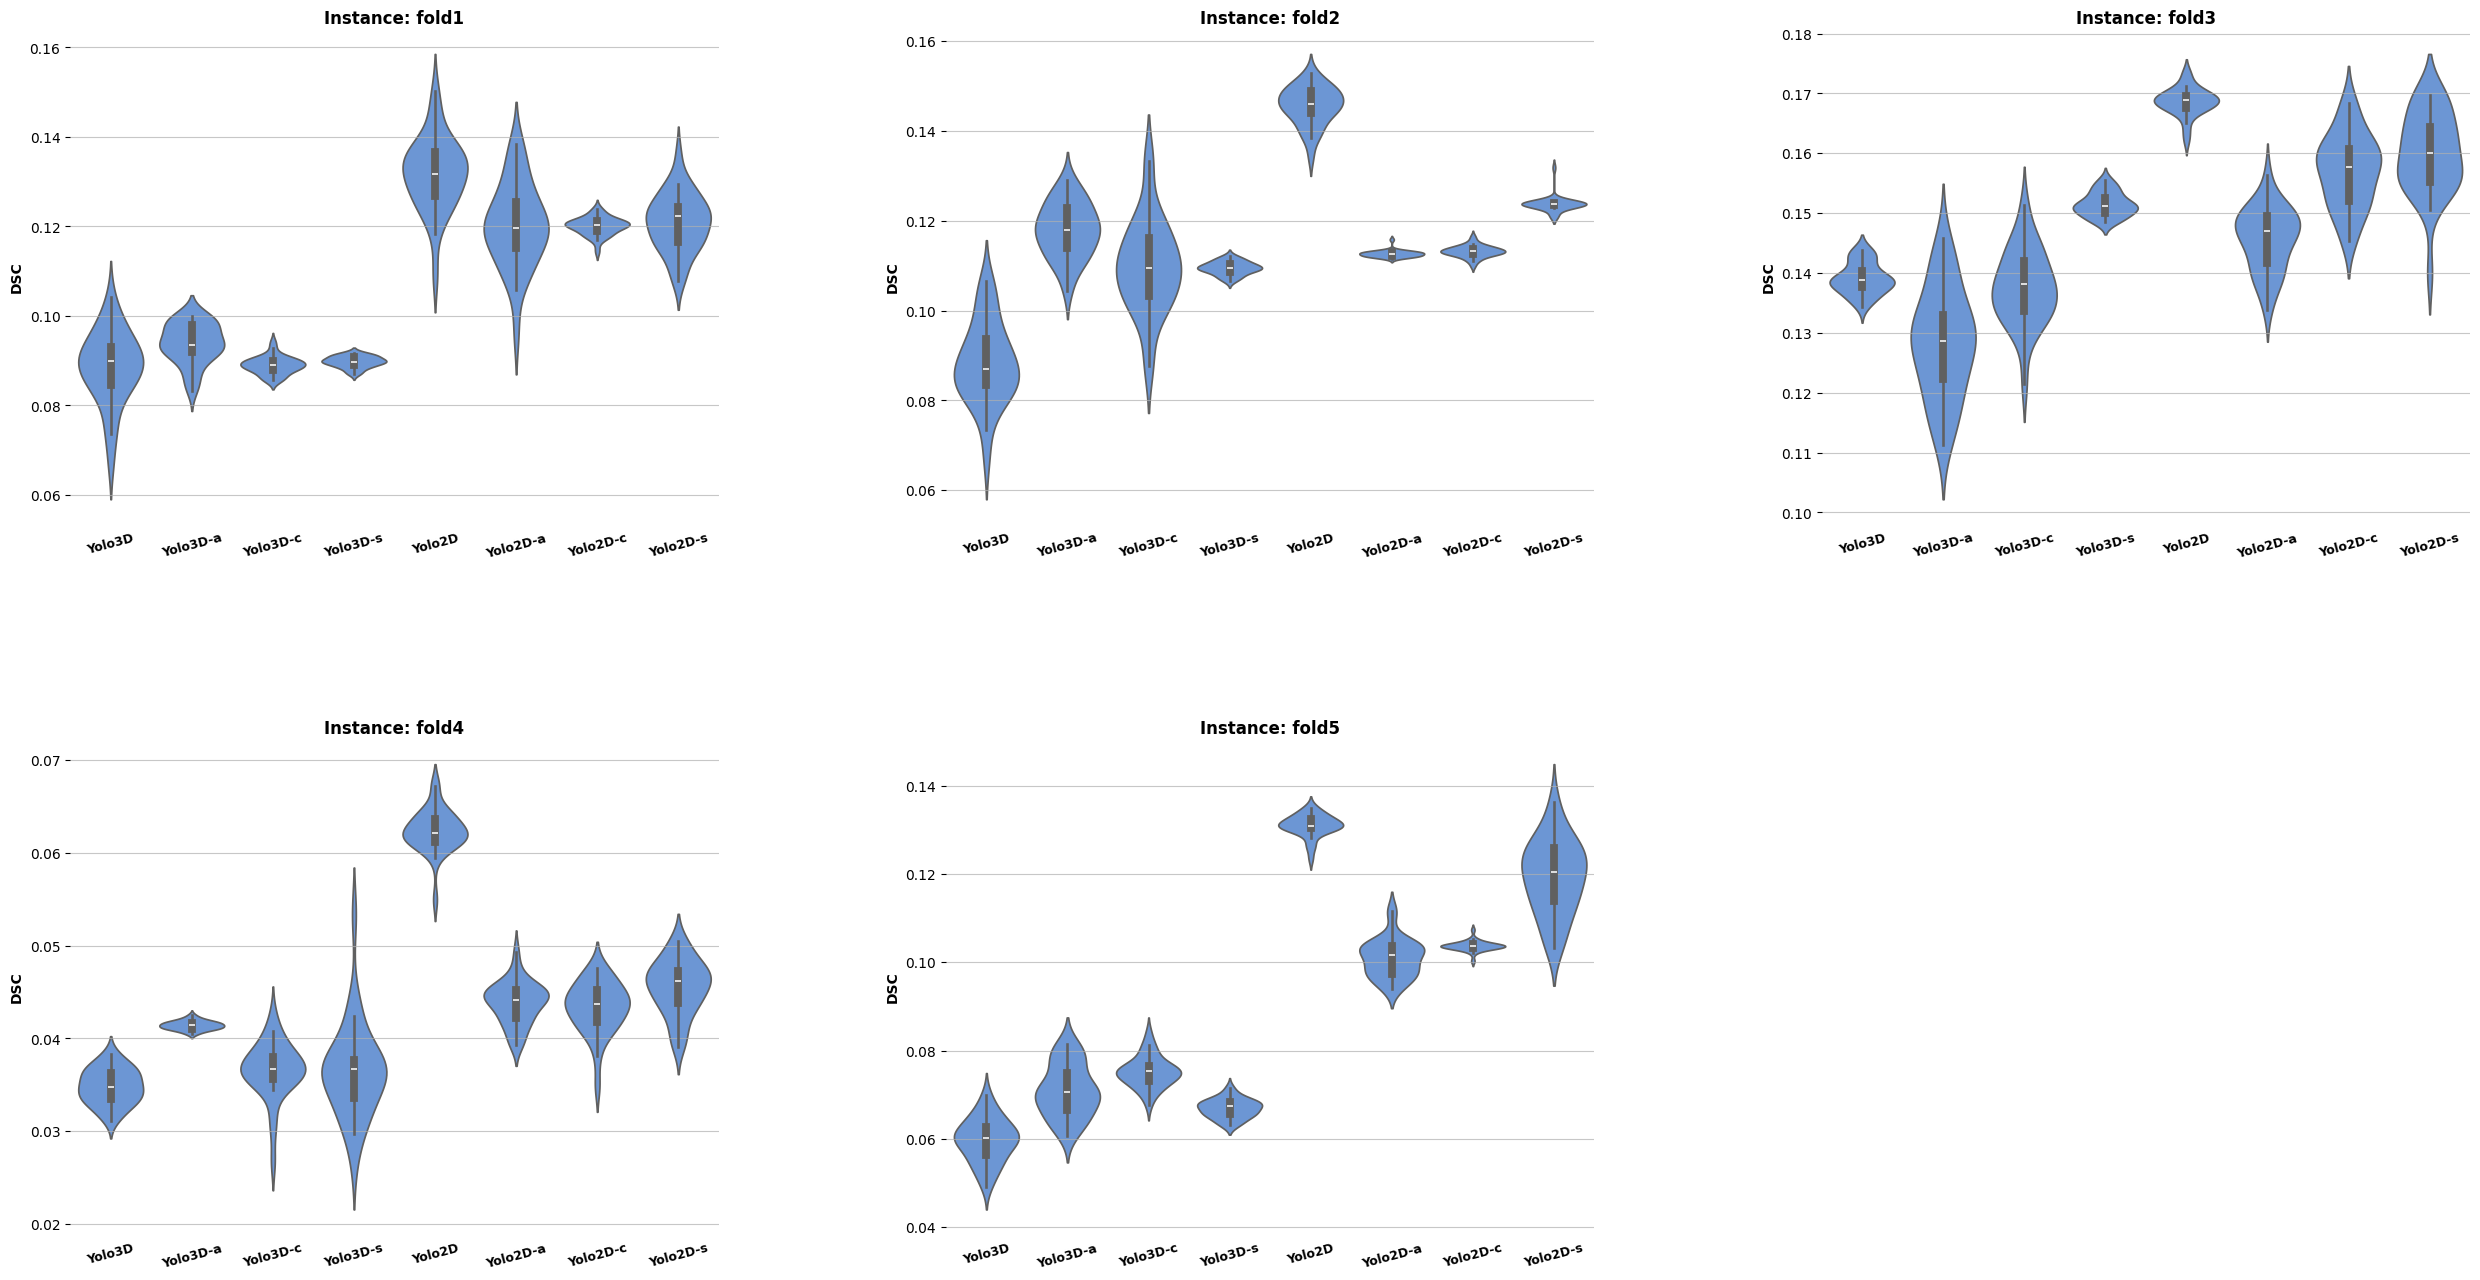

In [157]:
violin = Violin(yolo_data, metrics, "DSC")
violin.show_all_instances()

### Violin Plot nnUNet

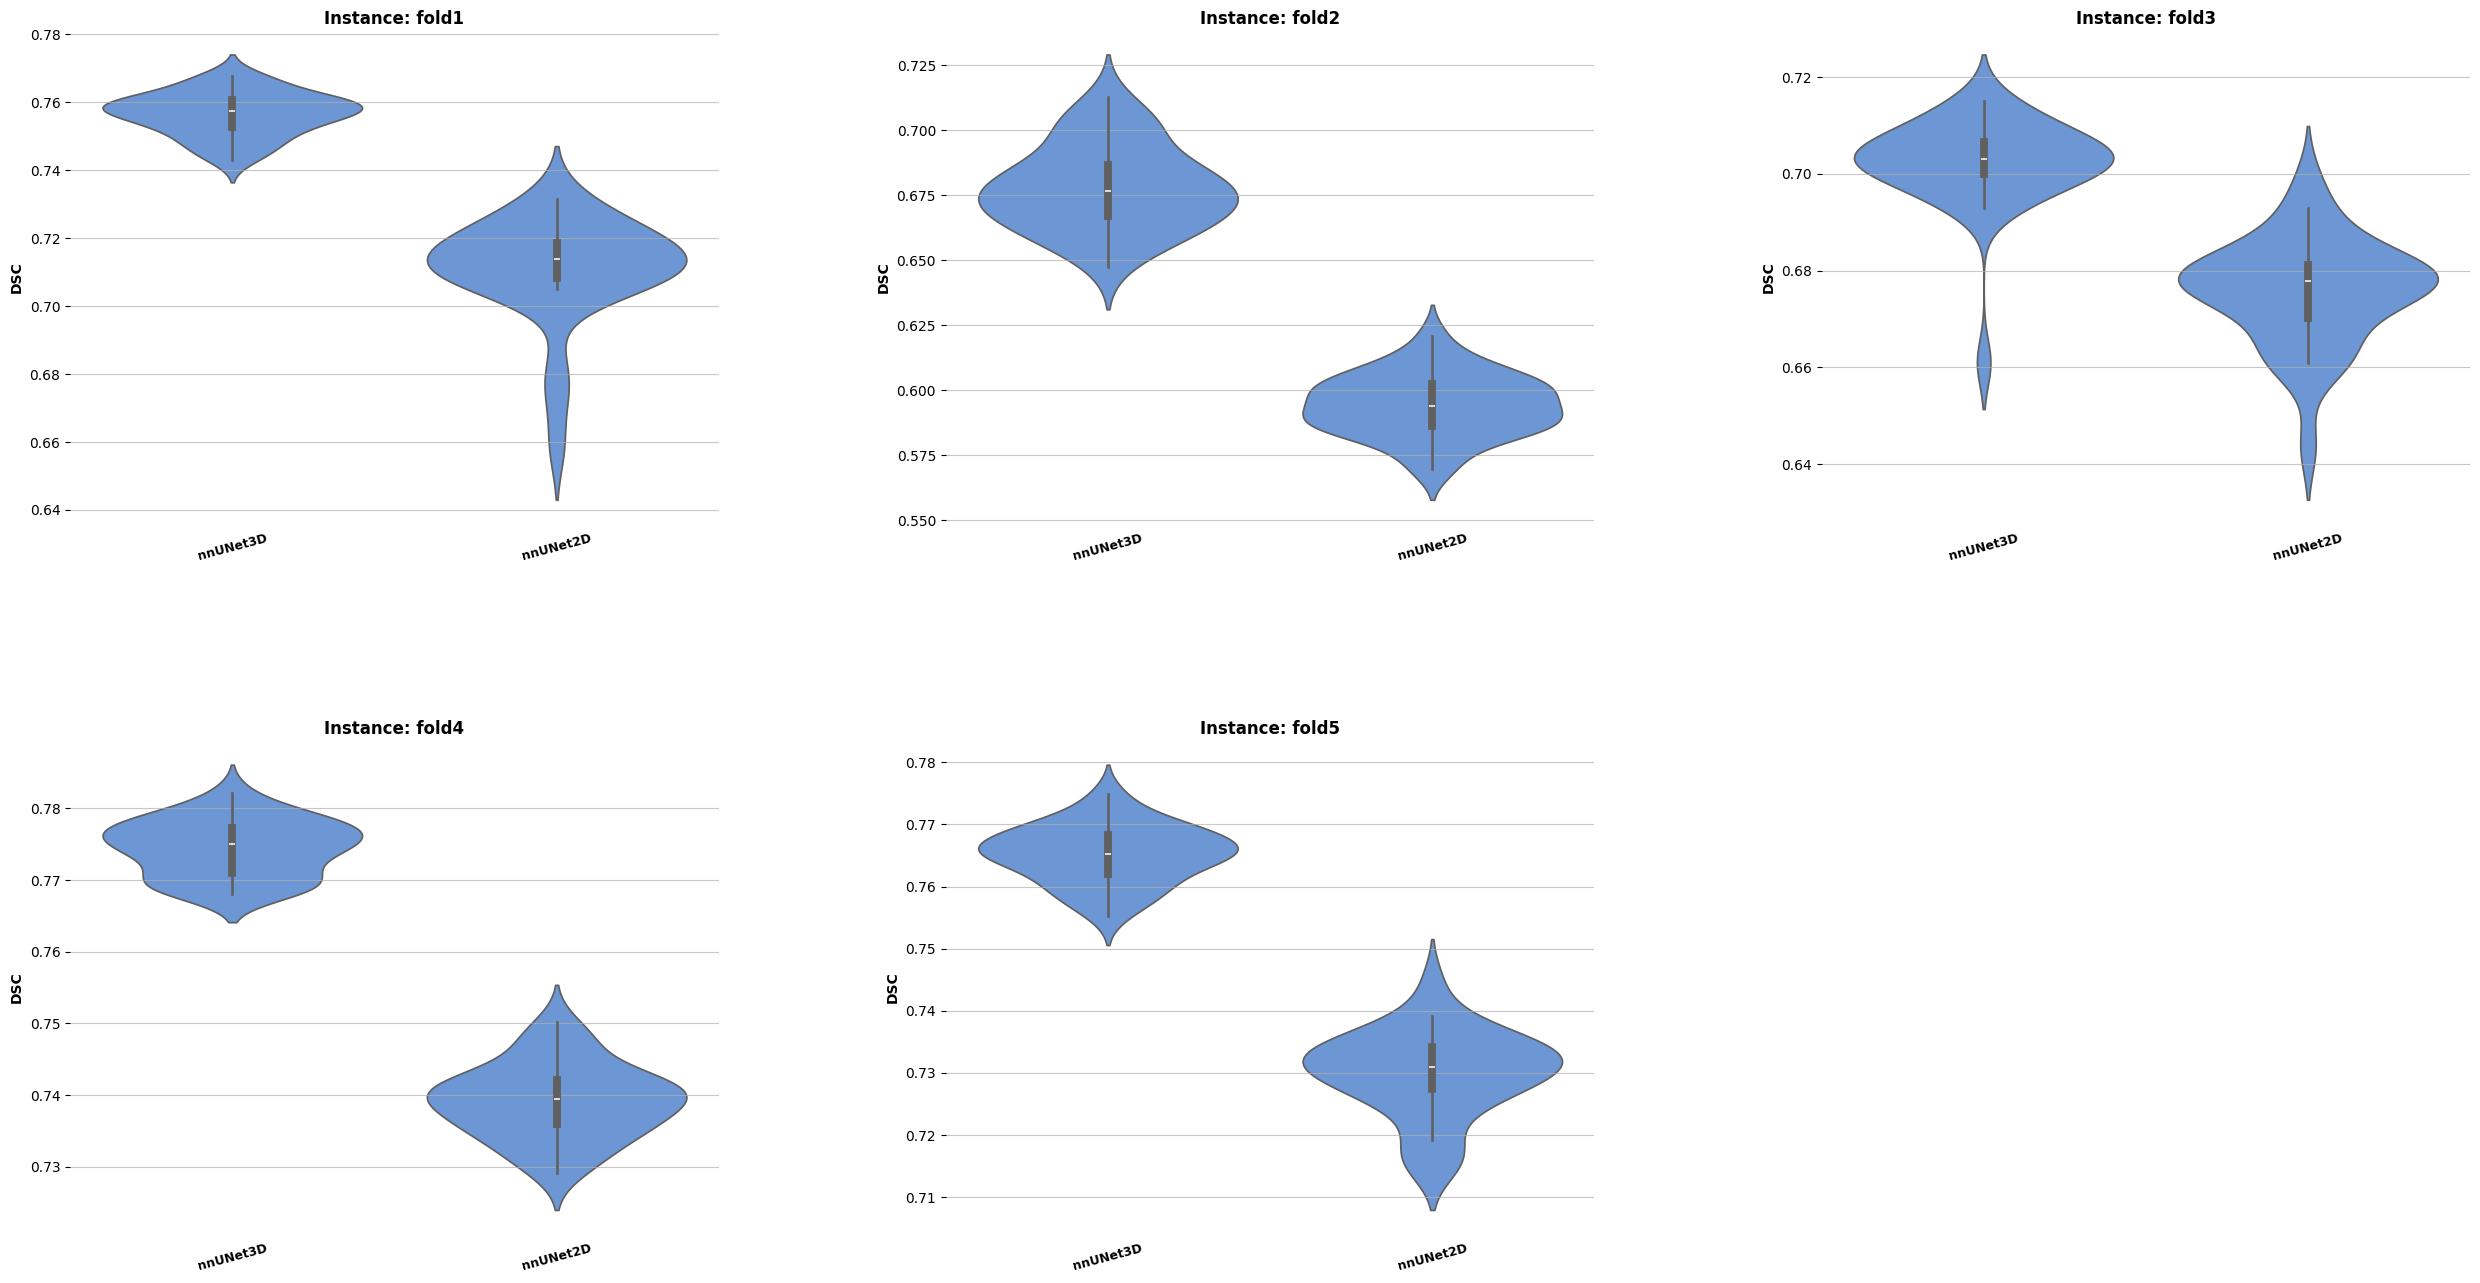

In [158]:
violin = Violin(nnUNet_data, metrics, "DSC")
violin.show_all_instances()

## HistPlot

A **histogram** (or **histoplot**) is another graphical representation used to summarize the distribution of a dataset, but it differs from a boxplot in how it organizes and displays the data.

In a **histogram**, the data is divided into **bins** or **intervals**, and the frequency of data points within each interval is represented by the height of a bar. The **x-axis** represents the values or ranges of the dataset (the bins), while the **y-axis** represents the frequency or count of data points within each bin. This type of plot is particularly useful for understanding the **shape** of the data distribution, including whether the data is **skewed**, **normal**, or exhibits any other patterns.

### Key Features of a Histogram:
1. **Bins**: The data is grouped into bins, and the number of bins can affect the appearance of the histogram. Too few bins may oversimplify the distribution, while too many bins may make the plot noisy and harder to interpret. The size of the bins often depends on the range of the data and the level of detail desired.
   
2. **Frequency**: The height of each bar corresponds to the number of data points within that bin. A taller bar indicates a higher frequency of data in that range.

3. **Shape of Distribution**: The histogram visually reveals the overall shape of the distribution. For example, a bell-shaped histogram suggests that the data is normally distributed, while a skewed histogram indicates that the data is not symmetrically distributed.

4. **Outliers**: Unlike the boxplot, histograms don't explicitly highlight outliers, but you can identify outliers as bins with significantly lower frequencies compared to neighboring bins. If a bin is far from the main body of the distribution, it might suggest the presence of unusual data points.

### Interpretation:
- **Skewness**: If the histogram's tail is stretched out on the right, it suggests **right skewness** (or positive skew), indicating that the data has more values on the lower end but some very high values. Conversely, if the tail is stretched out on the left, it suggests **left skewness** (or negative skew).
  
- **Peaks**: A histogram with one peak is **unimodal**, while one with multiple peaks could be **multimodal**, suggesting that the dataset may consist of more than one underlying distribution.

- **Central Tendency**: You can visually identify the central tendency (such as the mean or median) by looking at where the majority of the data is concentrated. In symmetric distributions, the mean and median are close to each other.

- **Spread**: The width of the histogram gives an idea of the spread of the data. A wider histogram indicates more variability, while a narrower one suggests that the data points are more tightly grouped around the central tendency.

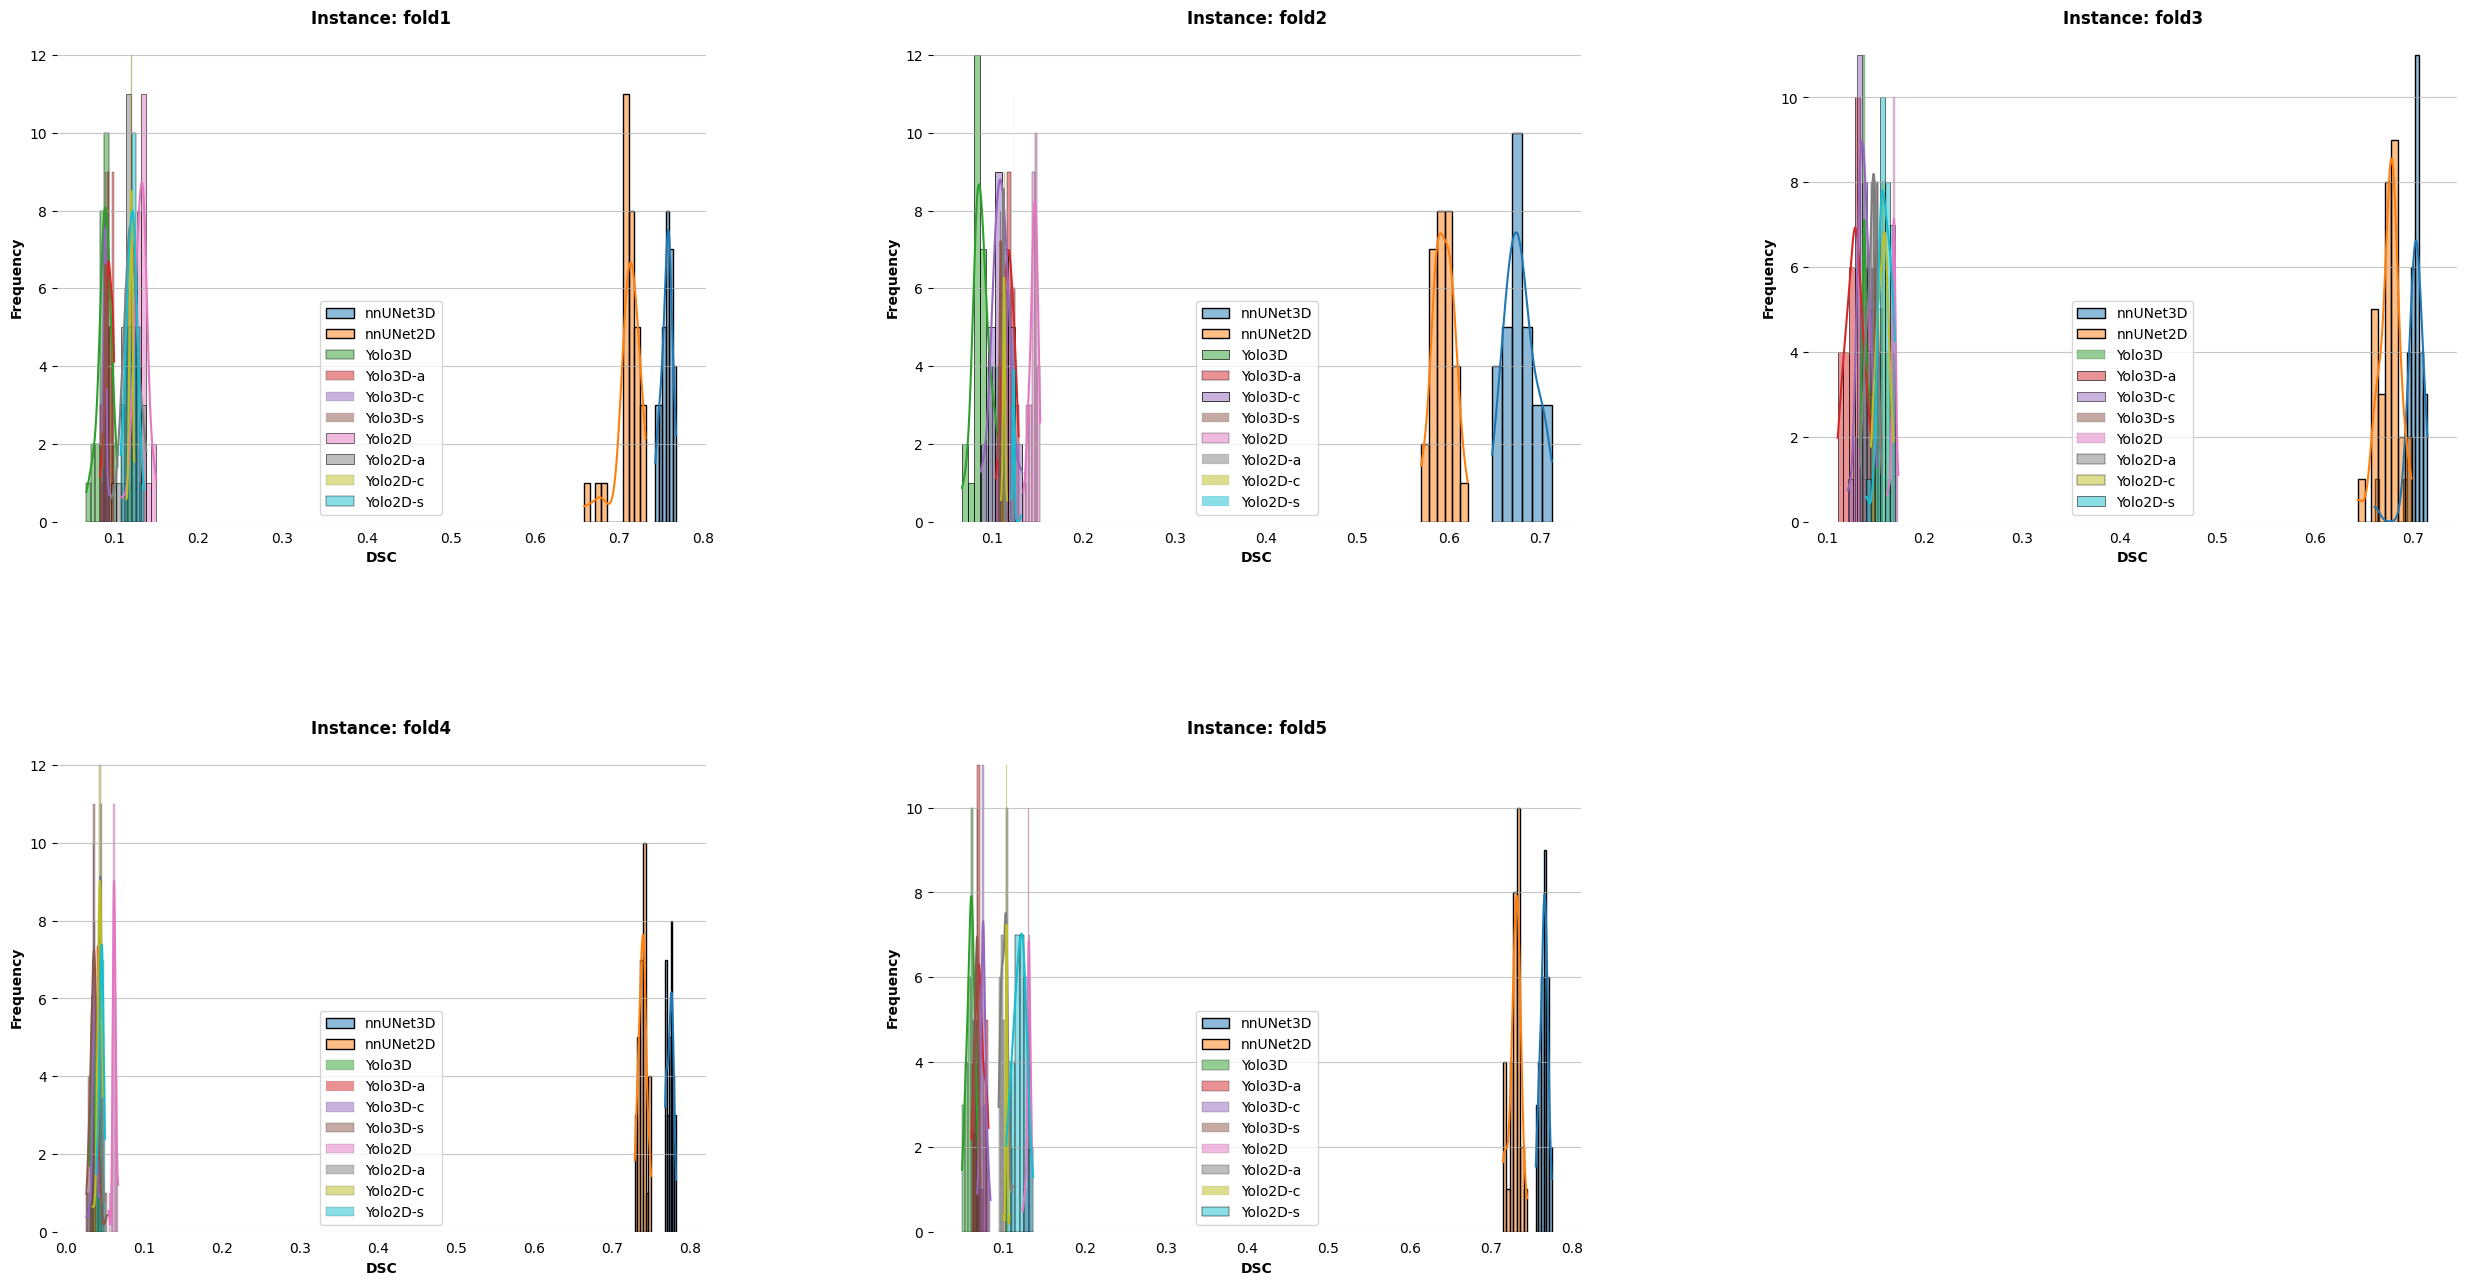

In [159]:
histoplot = HistoPlot(yolo_nnUNet_data, metrics, "DSC")
histoplot.show_all_instances()

### HistPlot Yolo

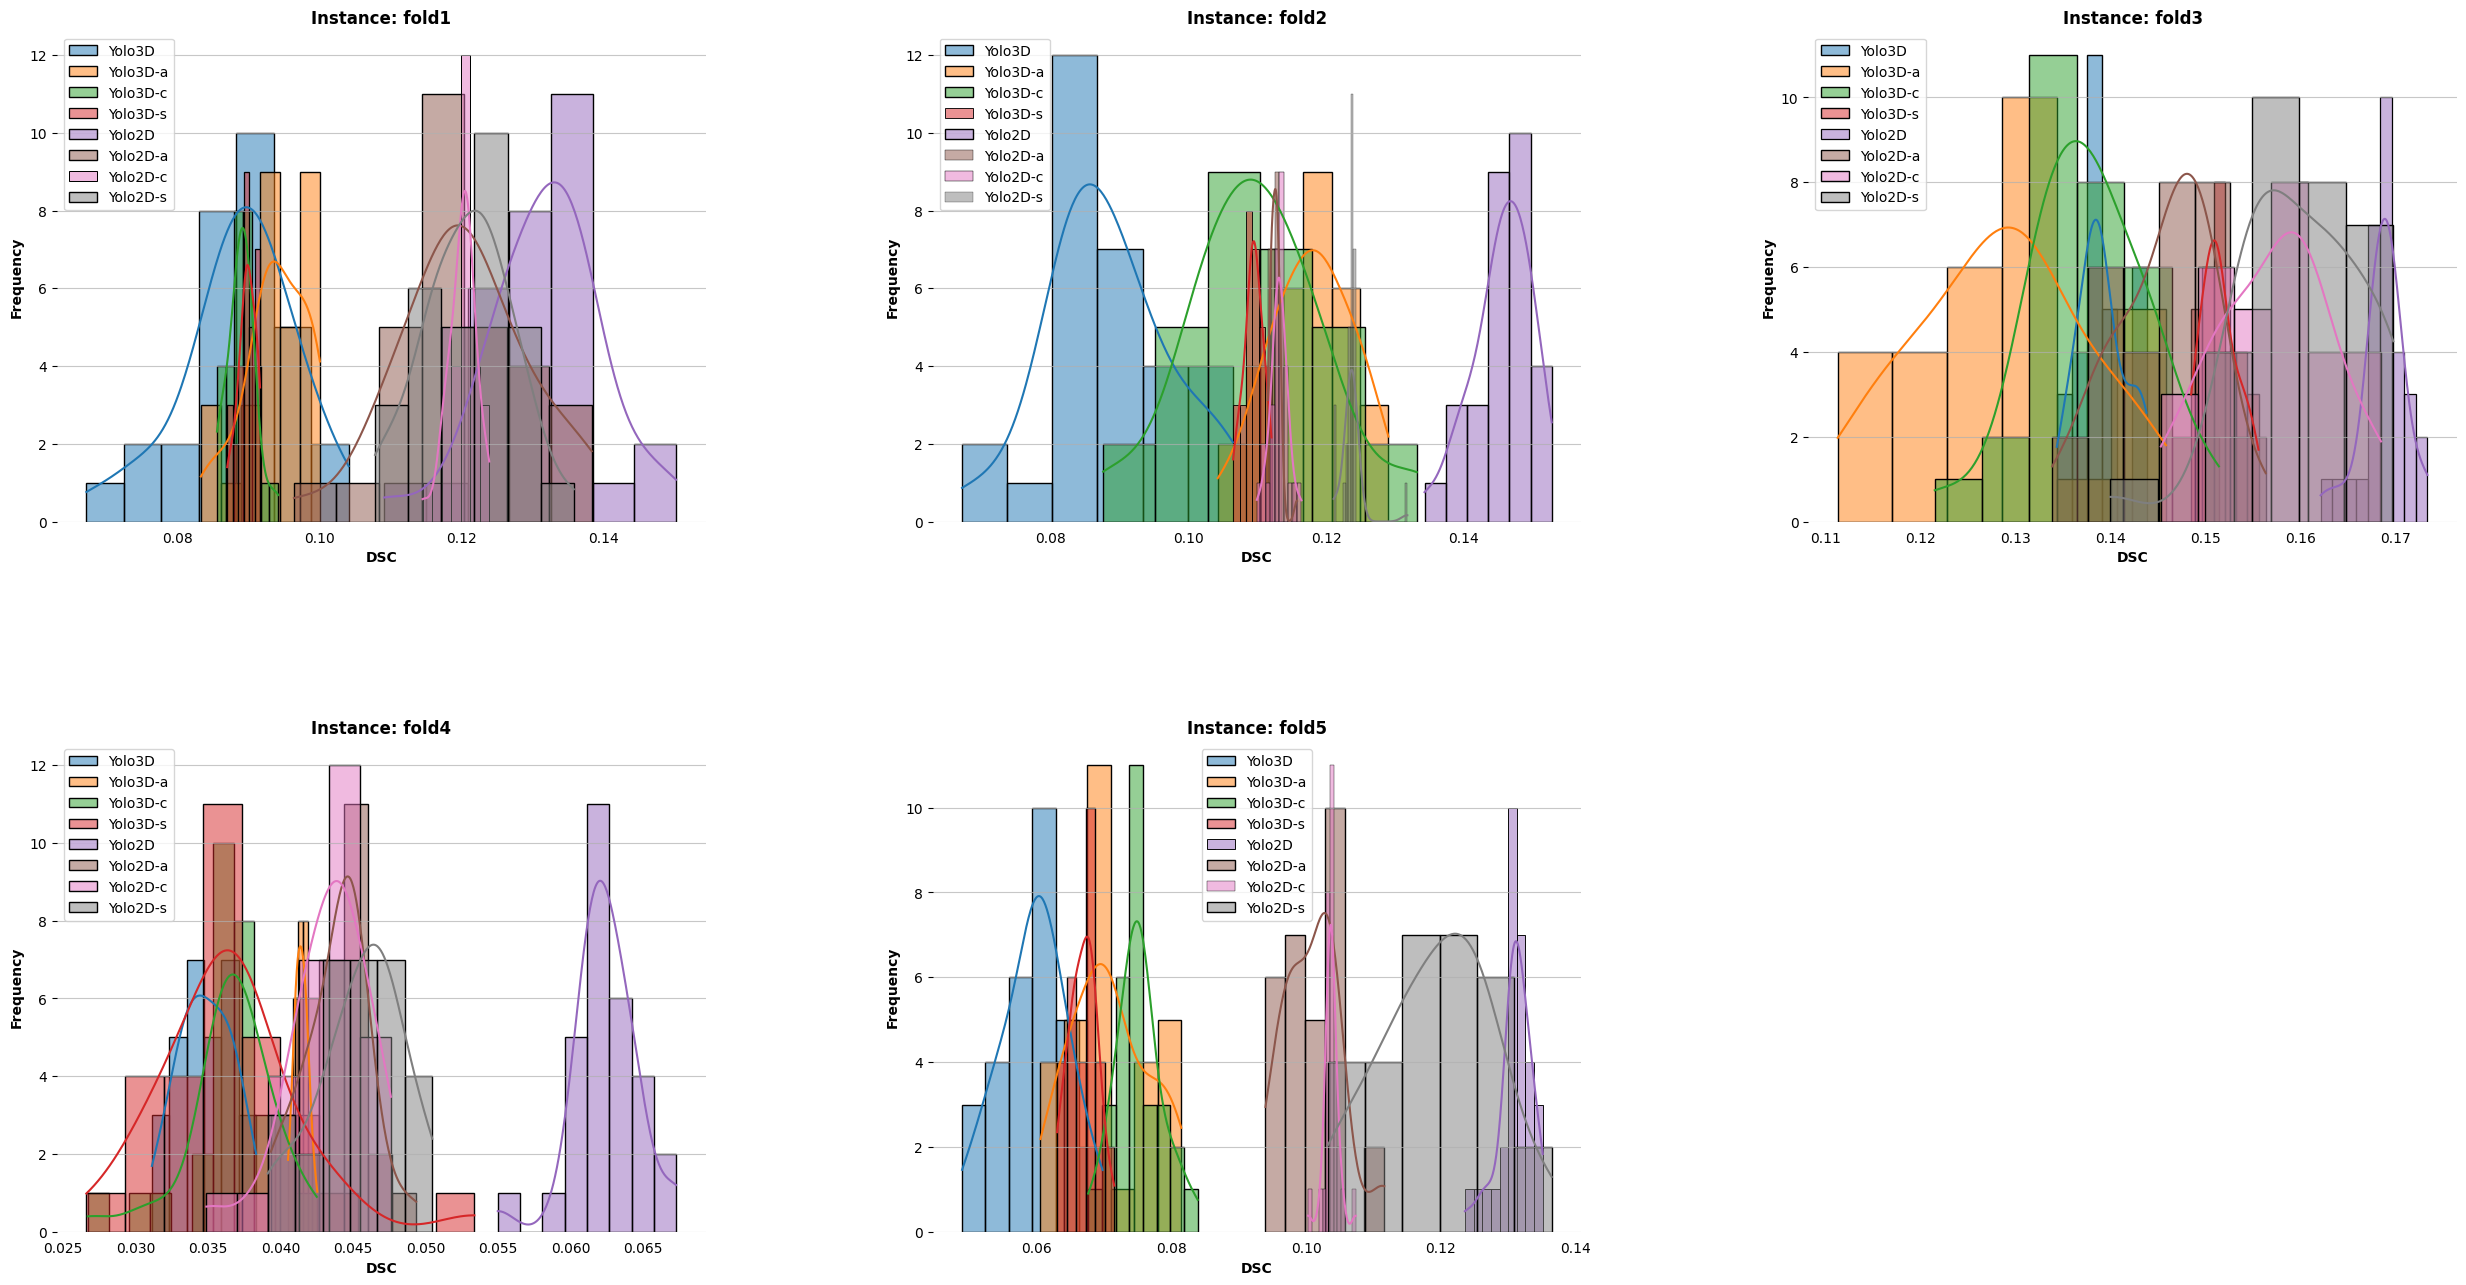

In [160]:
histoplot = HistoPlot(yolo_data, metrics, "DSC")
histoplot.show_all_instances()

### HistPlot nnUNet

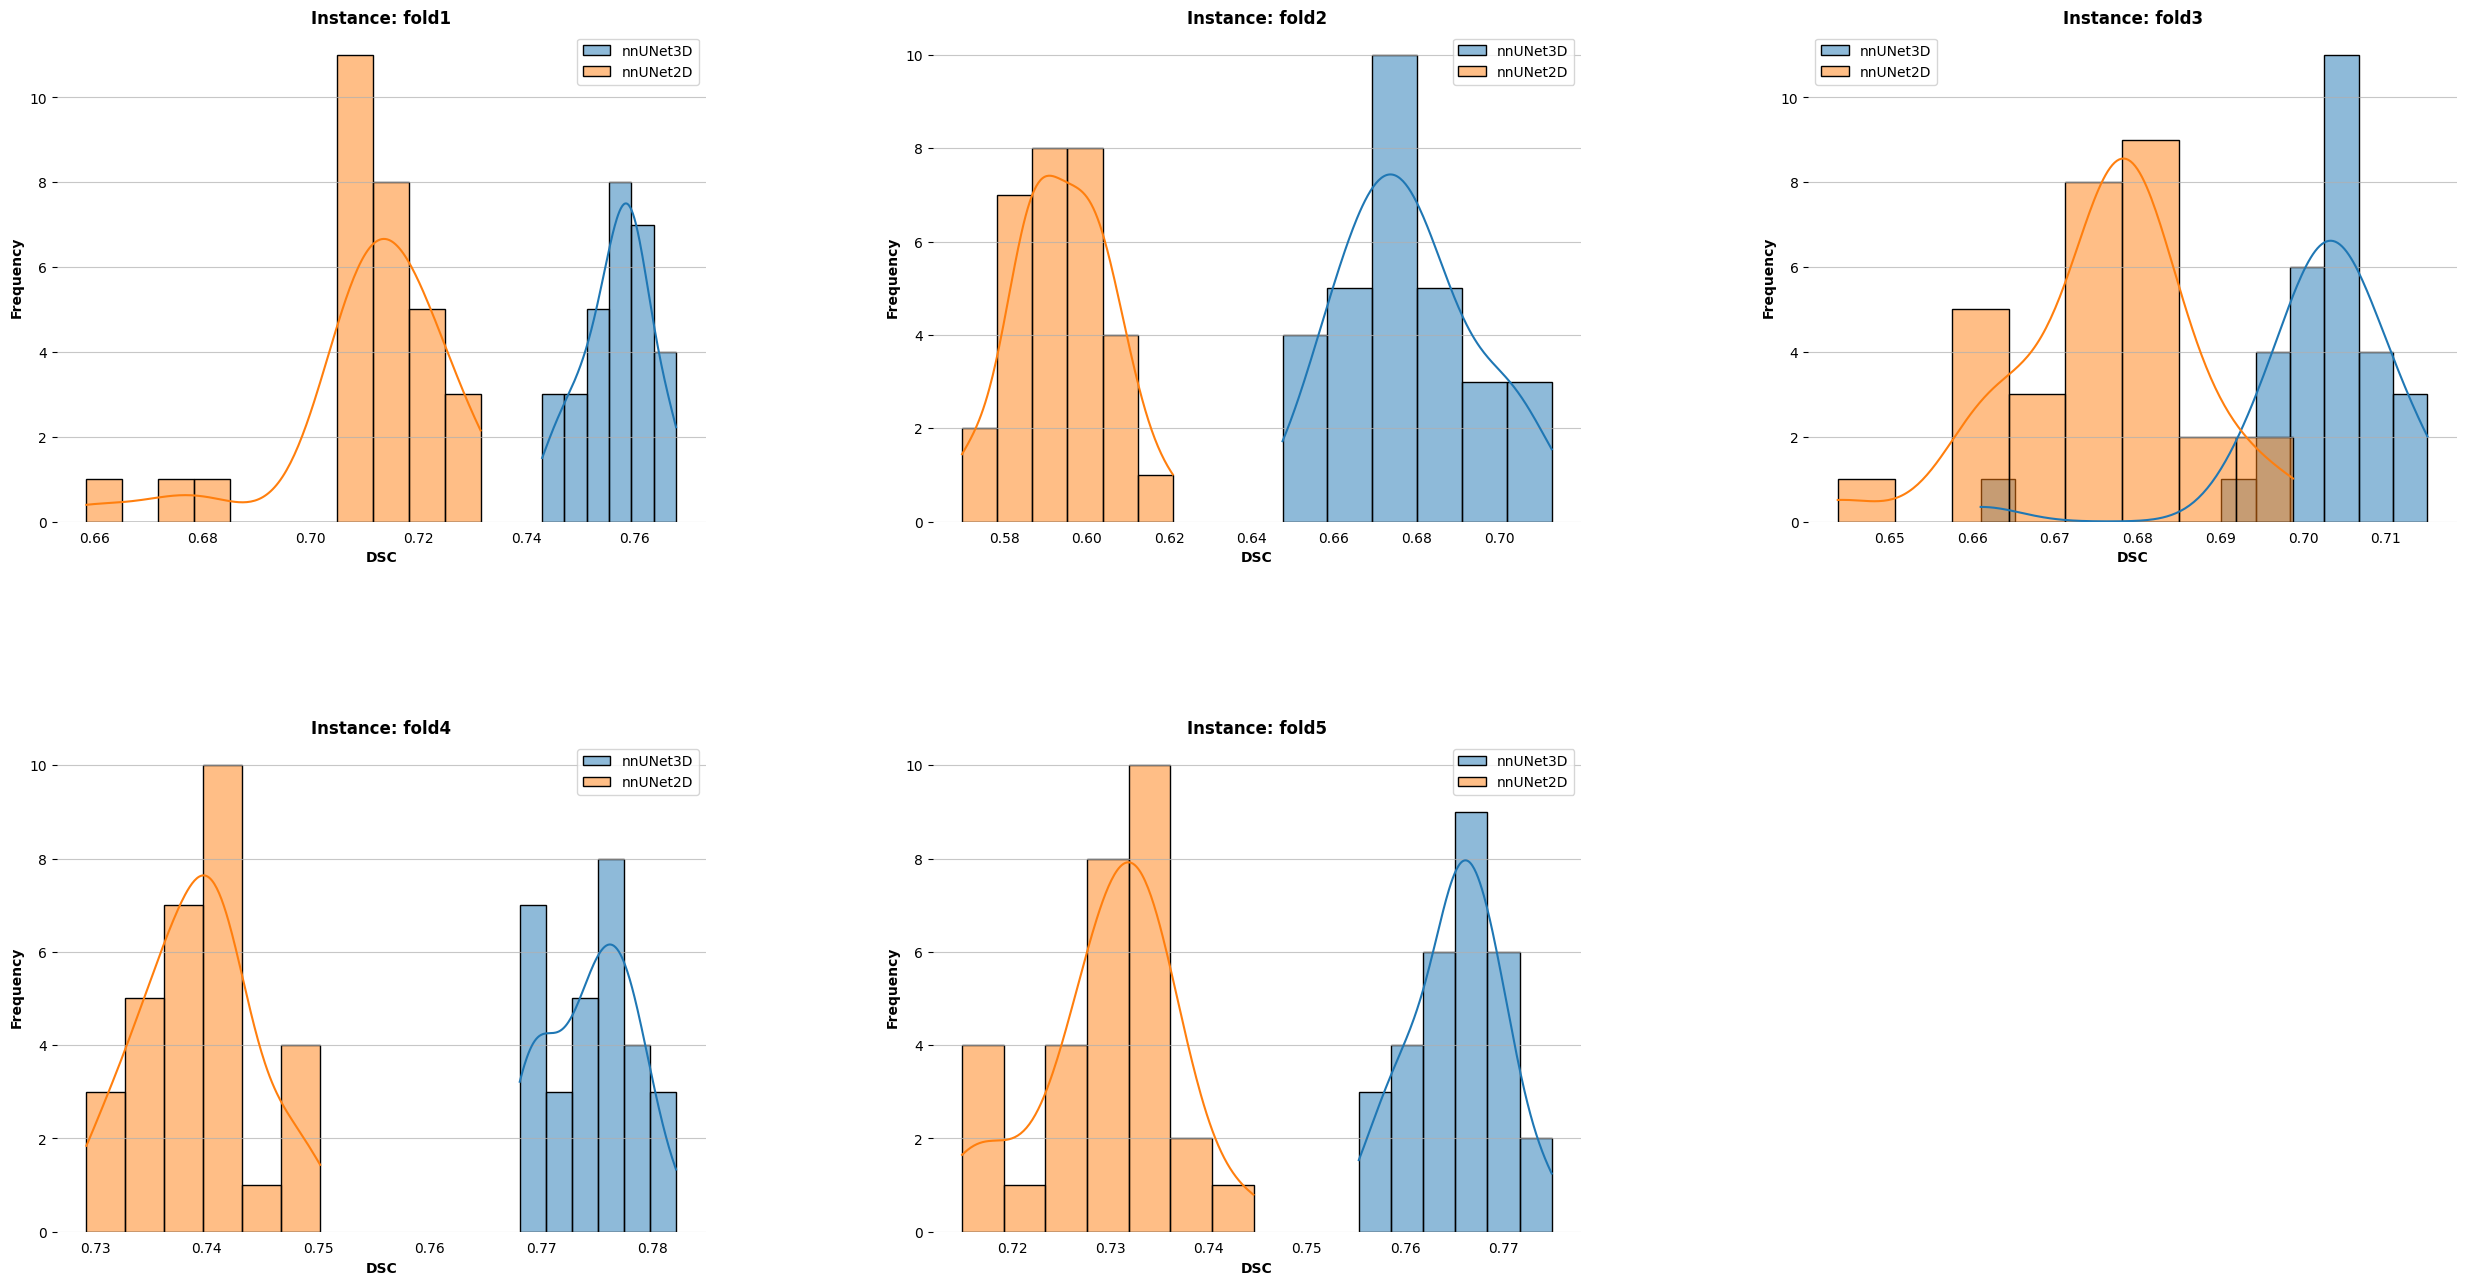

In [161]:
histoplot = HistoPlot(nnUNet_data, metrics, "DSC")
histoplot.show_all_instances()

## Critical Distance Graph

A critical distance (CD) graph is used to compare the performance of multiple algorithms statistically. It is typically generated using the Nemenyi test, which is a post-hoc test applied after a Friedman test has shown significant differences between algorithms. 

In this graph:
- Each algorithm is assigned a rank based on its performance on a metric (e.g., accuracy, hypervolume, etc.) across multiple datasets or experiments.
- The average rank of each algorithm is plotted on a horizontal axis.
- A critical distance (CD) value is calculated, representing the threshold for statistically significant differences between algorithm ranks.
- Algorithms connected by horizontal lines are statistically indistinguishable within the critical distance, meaning their performance differences are not significant at the chosen confidence level.

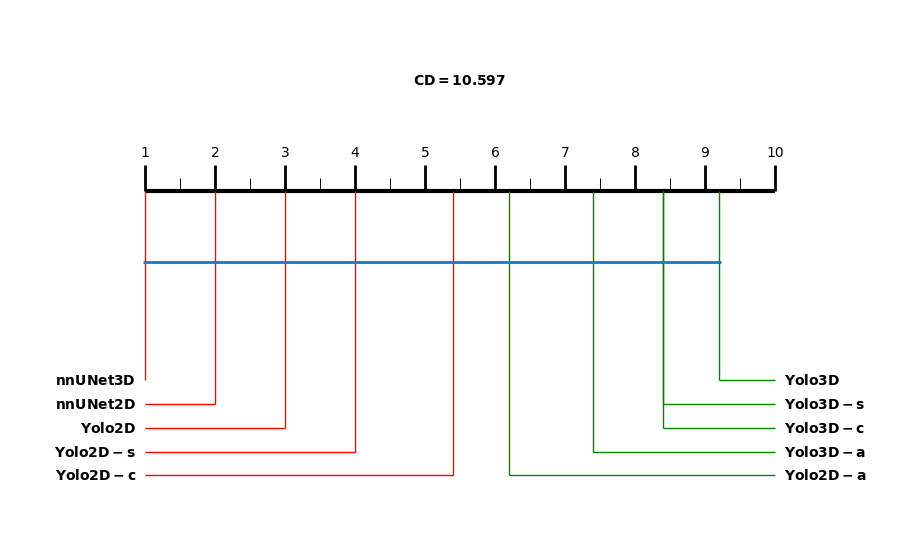

In [162]:
cdplot = CDplot(yolo_nnUNet_data, metrics, 'DSC')
cdplot.show()

### Critical Distance Graph Results

As expected, the Critical Distance Graph displays, in order, which were the **best-performing models**:

1. 🥇 **nnUNet3D**
2. 🥈 **nnUNet2D**
3. **Yolo2D**
4. *Yolo2D-s*
5. *Yolo2D-c*
6. *Yolo2D-a*
7. *Yolo3D-a*
8. *Yolo3D-c*
9. *Yolo3D-s*
10. **Yolo3D**

> ✅ This ranking confirms expected performance trends across the tested architectures.

## LaTeX report Generation

Lastly, we offer a variety of LaTeX reports tailored for different purposes, including scientific articles and presentations (take into account that only the .tex source code is provided and you will need an external tool like overleaf to render the LaTeX code into pdf format). Below are the four types of LaTeX reports you can generate, along with a brief explanation of each:  

1. **Median Table**  
   - **Description**: Displays the median results of the experimental data in a structured tabular format.  
   - **Purpose**: Useful for summarizing central tendencies of your results and providing a quick overview.  
   - **Use Case**: Suitable for basic comparative analysis in situations where medians are the primary focus.

2. **Median Table with Friedman Test**  
   - **Description**: Extends the median table by incorporating the Friedman test results.  
   - **Purpose**: Highlights significant differences among multiple groups or algorithms, assuming a non-parametric distribution.  
   - **Use Case**: Ideal for analyzing and reporting results where ranking of methods or treatments is necessary.  

3. **Median Table with Wilcoxon Pairwise Test (Pivot-Based)**  
   - **Description**: Combines the median table with the results of Wilcoxon signed-rank pairwise tests using a pivot-based approach.  
   - **Purpose**: Provides insights into pairwise comparisons of the experimental groups relative to a designated pivot group.  
   - **Use Case**: Valuable for scenarios requiring focused comparisons against a baseline or reference algorithm.  

4. **Pairwise Wilcoxon Test Table (1-to-1 Comparison)**  
   - **Description**: Presents pairwise Wilcoxon signed-rank test results for direct 1-to-1 comparisons between groups.  
   - **Purpose**: Offers detailed insights into individual pair comparisons without the need for a pivot.  
   - **Use Case**: Suitable for comprehensive pairwise statistical analysis in experimental studies.  

As it was mentioned, what is generated is the LaTeX code. You would need an external tool or have LaTeX installed in your system but if you did render it you would obtain a pdf document with (in this case) a friedman table like this:

## Bayesian Posterior Plot

The graph is a **ternary plot**, which is used to visualize probabilistic comparisons among three categories. In the context of Bayesian statistical tests, ternary plots are often employed to compare the relative performance of two competing algorithms while also accounting for the possibility of no significant difference.

Each point in the ternary plot represents a comparison outcome from a statistical test, where:

- One axis represents the probability that **Algorithm A is better**.
- Another axis represents the probability that **Algorithm B is better**.
- The third axis represents the probability that **there is no meaningful difference** between the two.

The color intensity in the graph typically represents the density of points, indicating how often different probability distributions occur.

### Bayesian Sign Test
- The Bayesian Sign Test is a **simpler** statistical method that assesses the probability that one algorithm is better than another based on direct pairwise comparisons.
- It only considers **the direction of differences** (i.e., which algorithm performs better), ignoring the magnitude of the differences.
- It assumes that the comparisons are independent and does not account for the distribution of the differences.

In [163]:
metric = "DSC"
pivot = "Yolo2D"
sign = Pplot(yolo_data, metrics, metric, bayesian_test="sign")
rank = Pplot(yolo_data, metrics, metric, bayesian_test="rank")

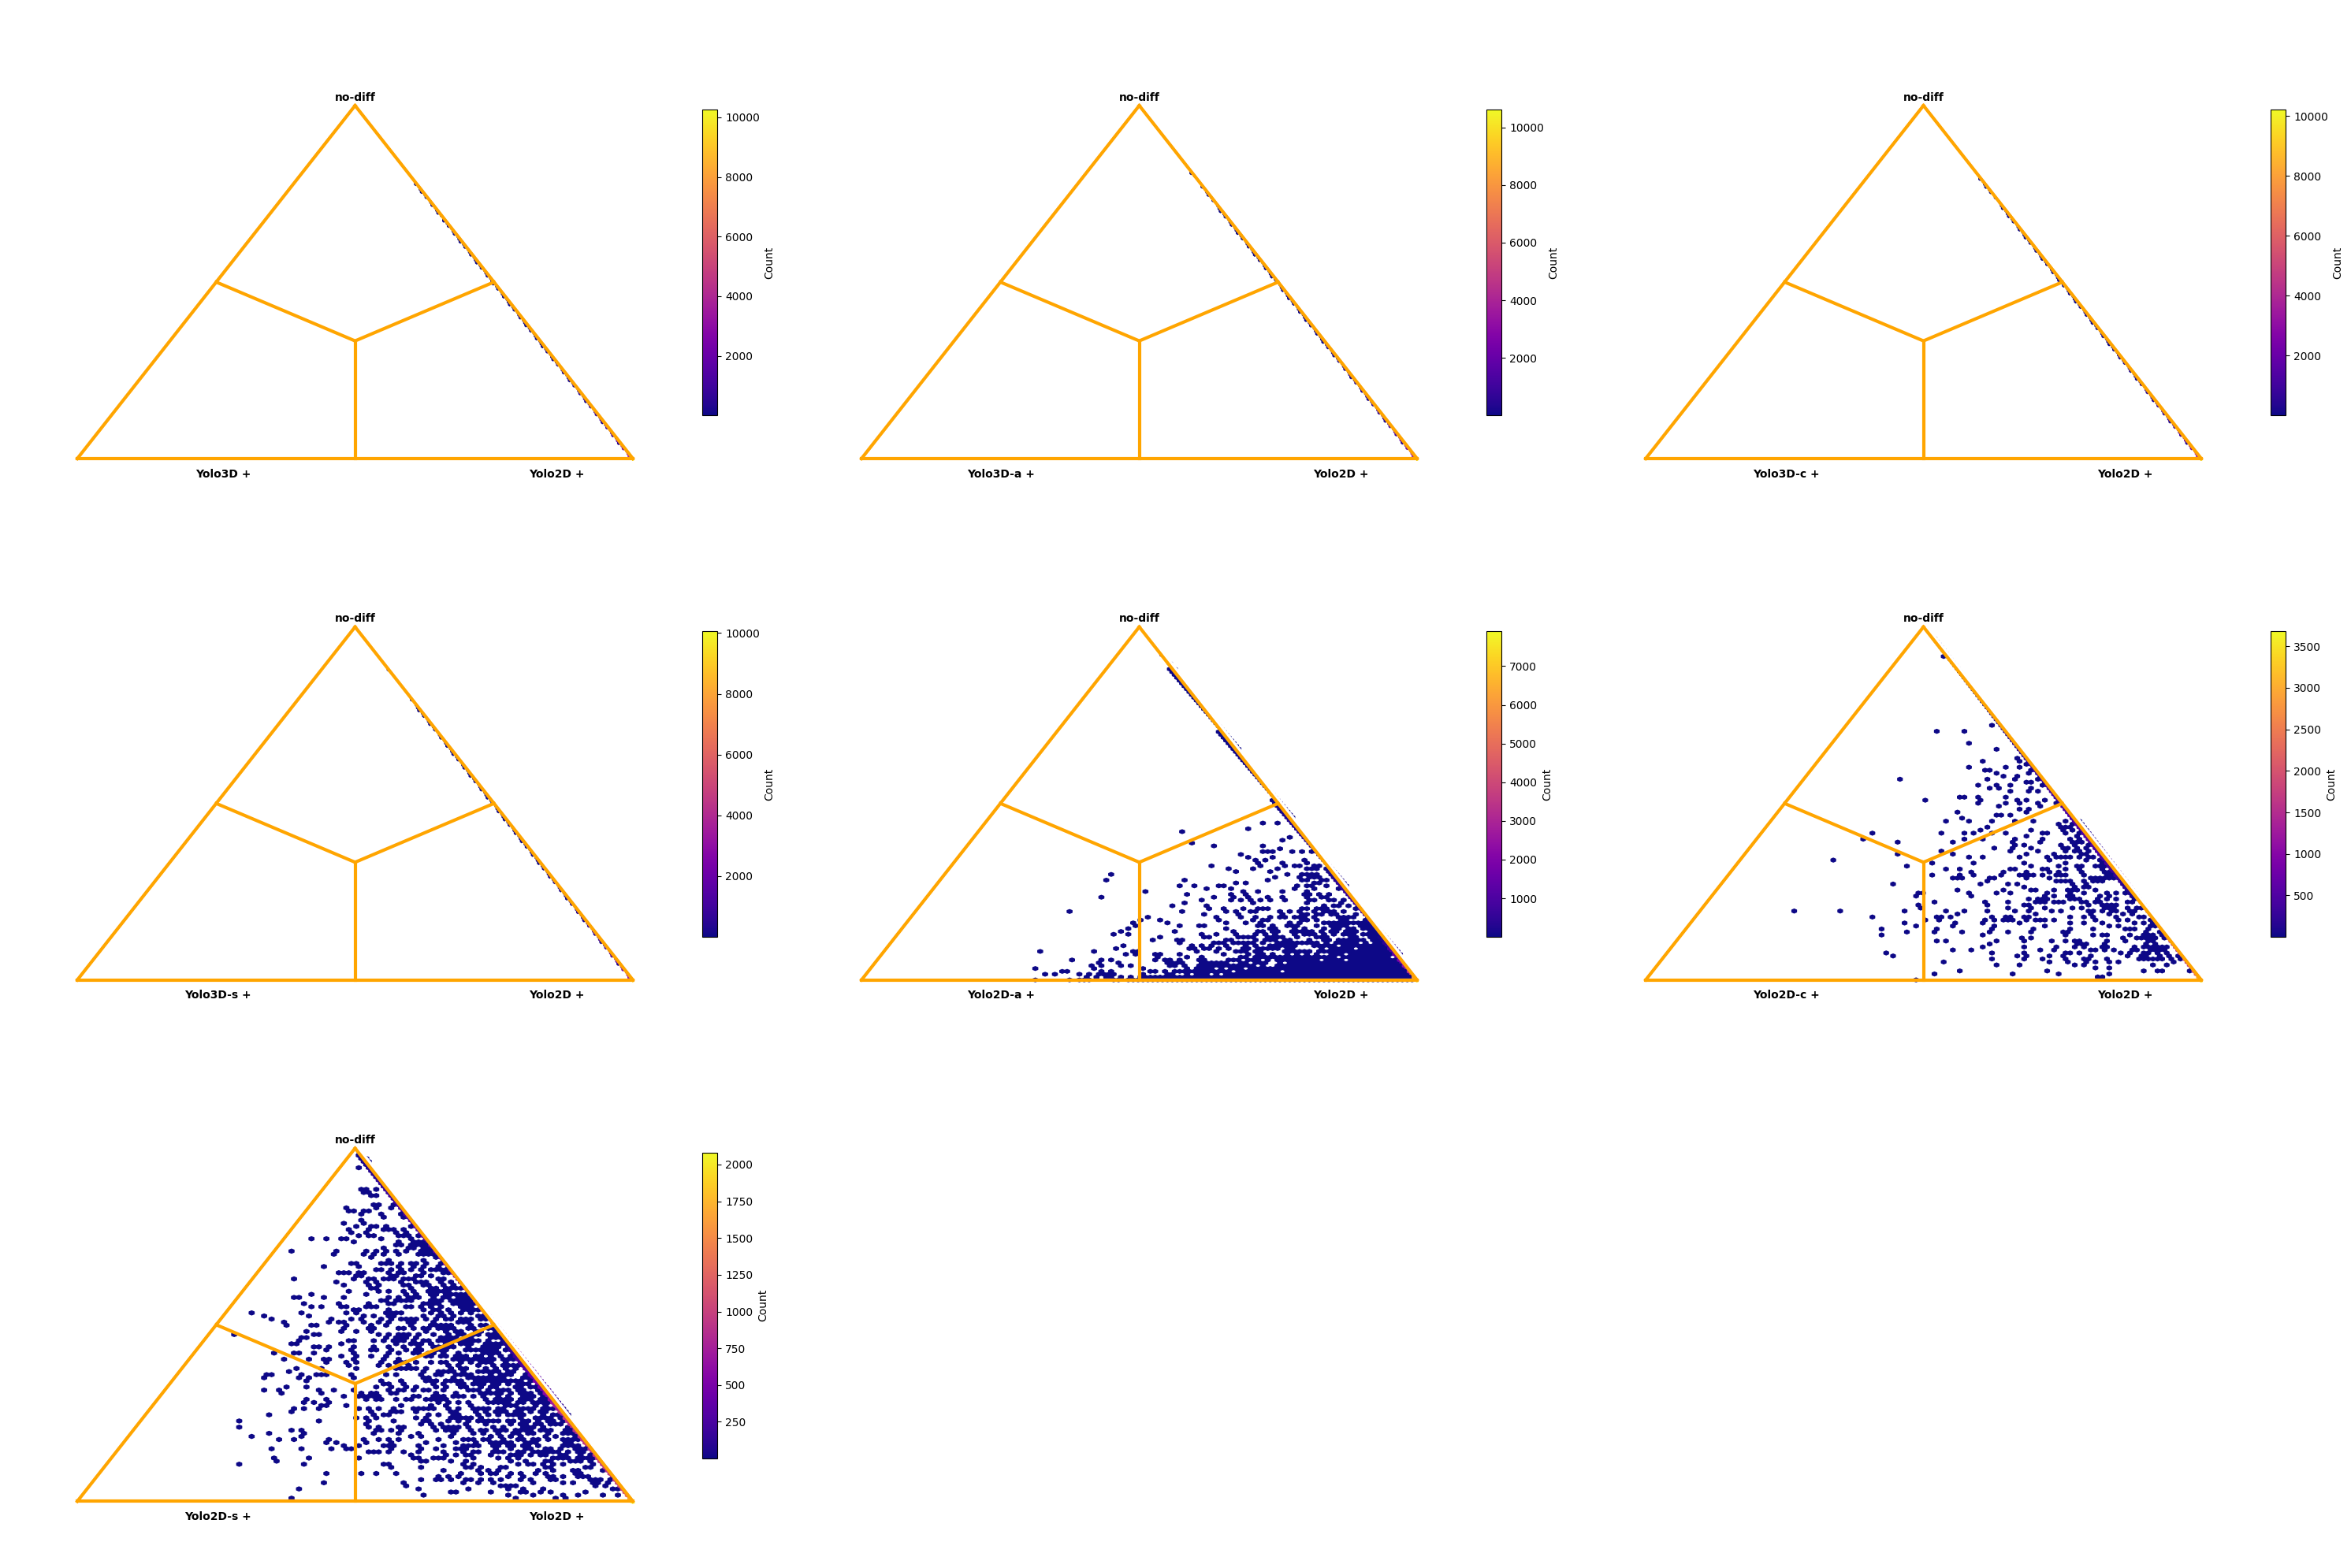

In [168]:
sign.show_pivot(pivot, width=30, heigth=20)

### Bayesian Signed Rank Test
- The Bayesian Signed Rank Test is **more informative** as it takes into account both the **direction and magnitude** of differences between algorithm performances.
- It is based on the **Wilcoxon Signed Rank Test**, which ranks the absolute differences and considers their signs.
- This test provides a more robust estimation of superiority, especially when differences are small or skewed.

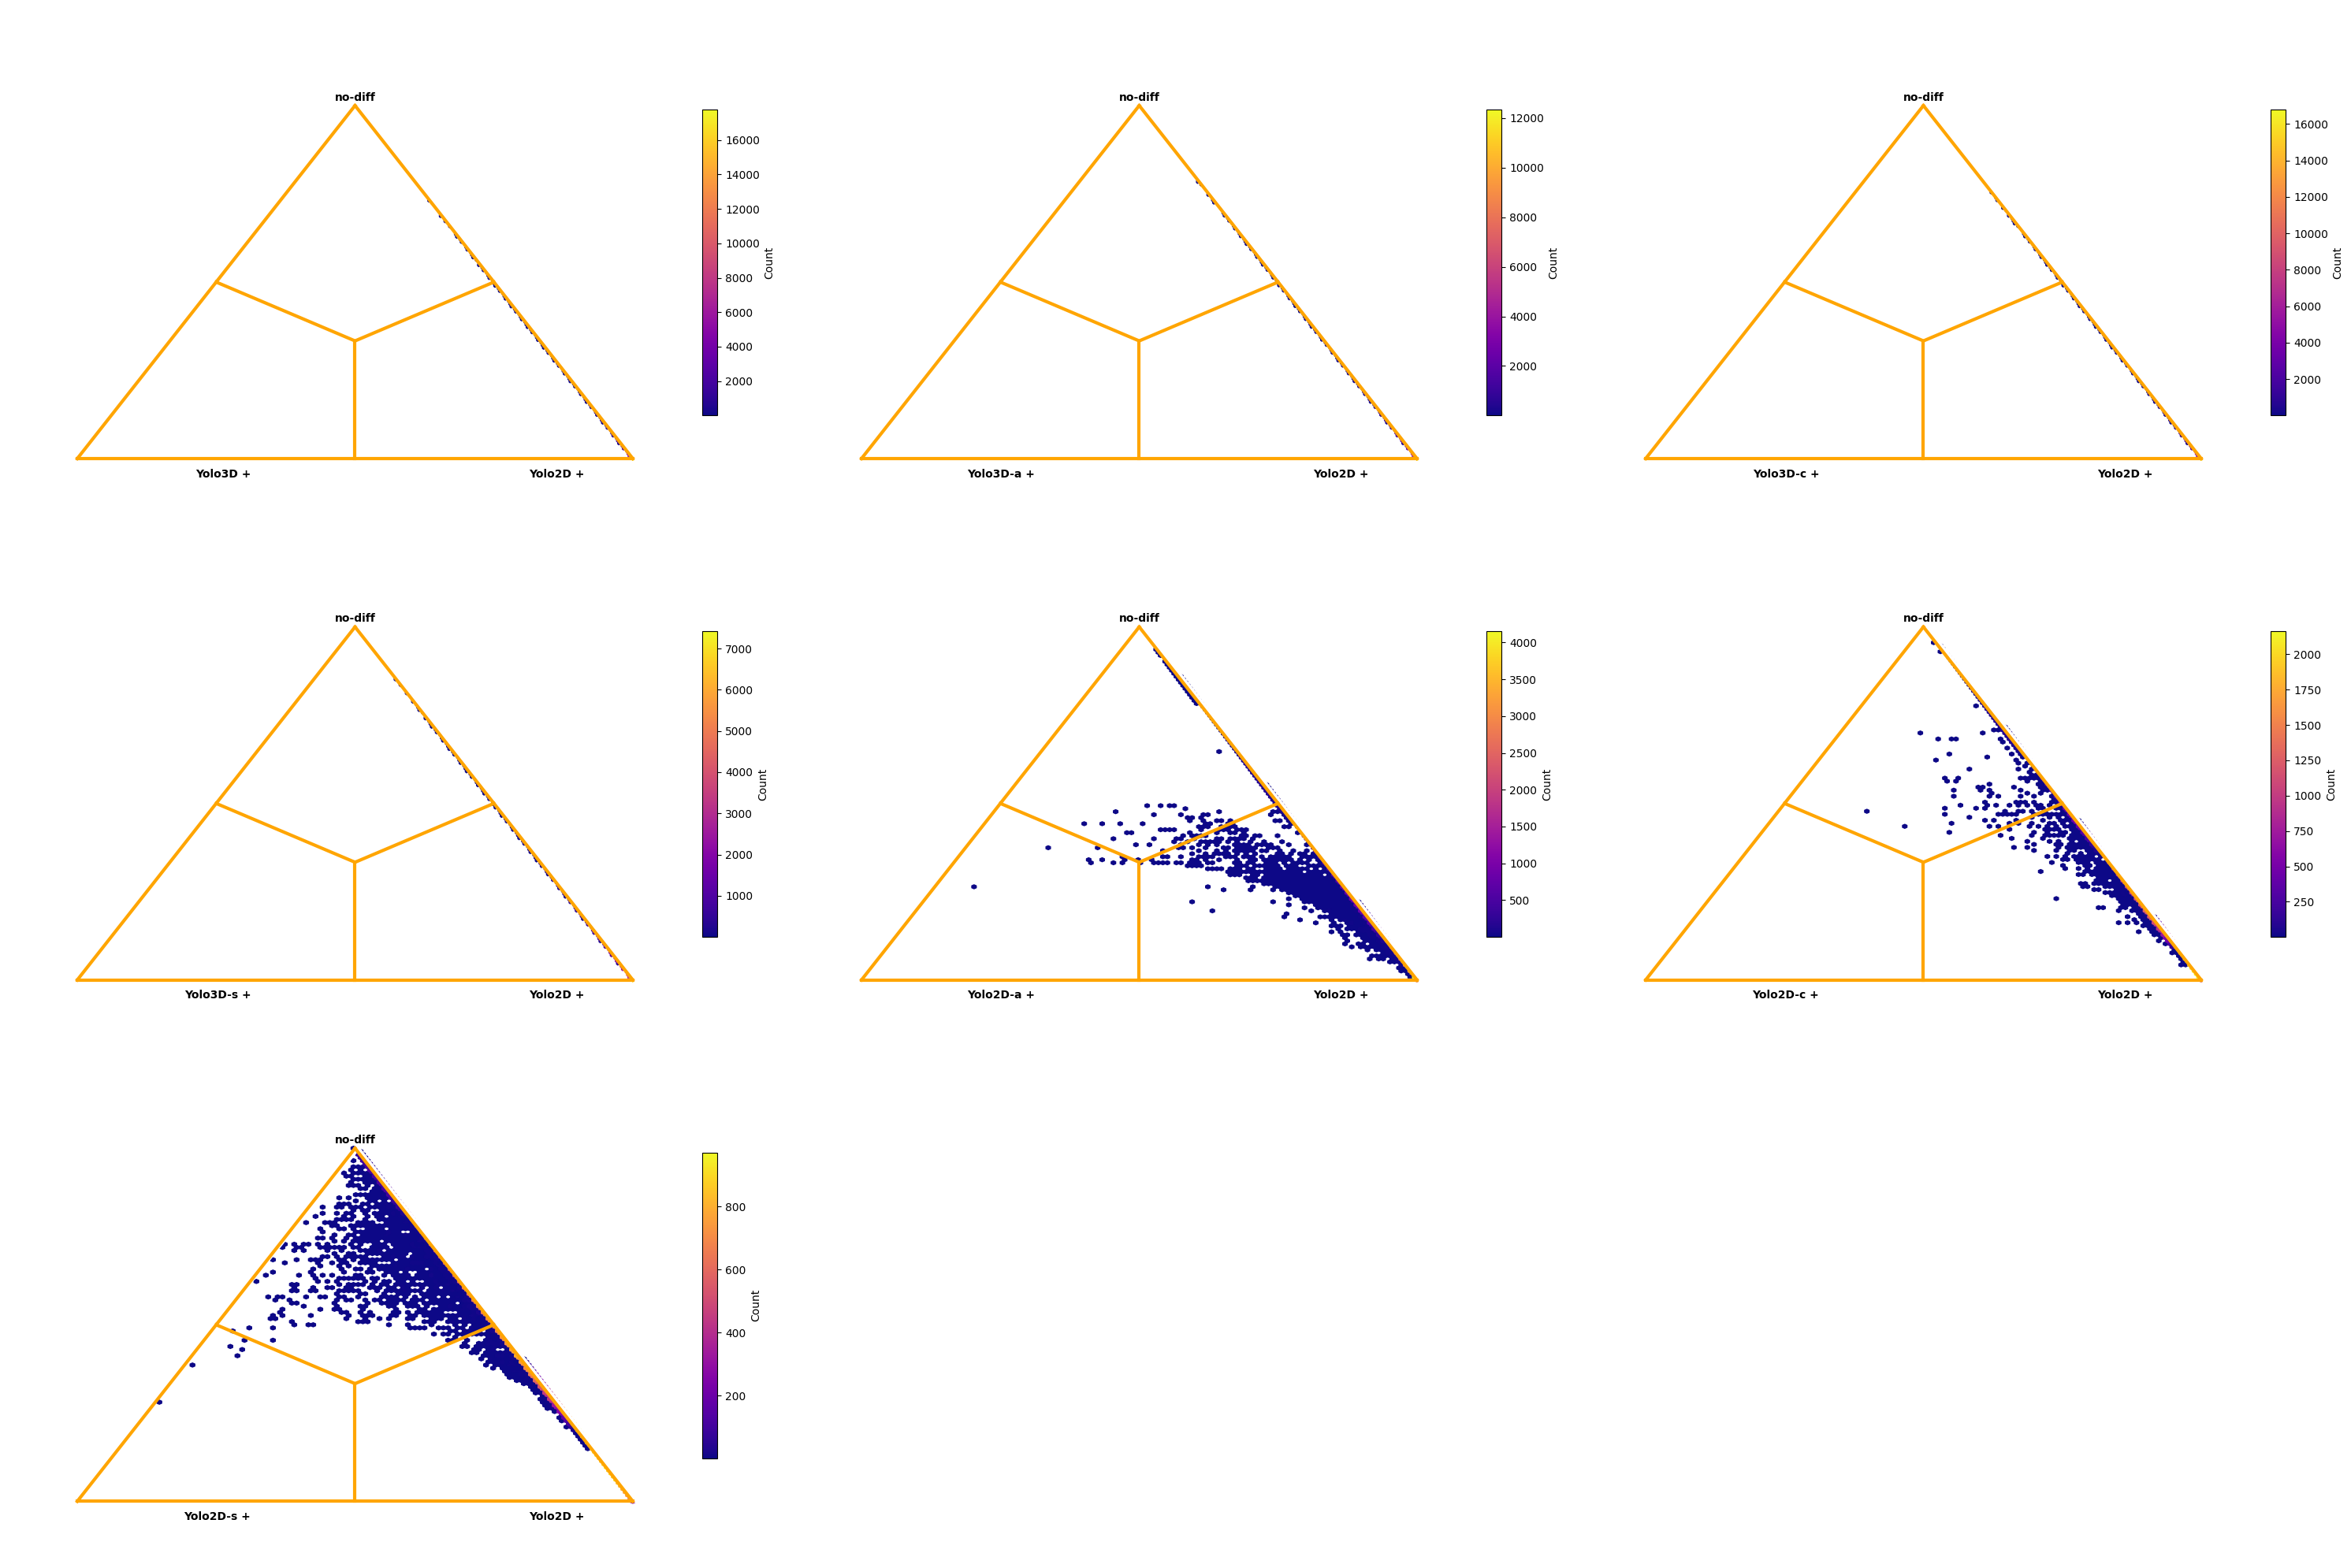

In [166]:
rank.show_pivot(pivot, width=30, heigth=20)

### Key Differences:
| Feature                 | Bayesian Sign Test          | Bayesian Signed Rank Test  |
|-------------------------|----------------------------|----------------------------|
| **Uses difference magnitude?** | ❌ No                        | ✅ Yes                       |
| **Based on ranks?**     | ❌ No                        | ✅ Yes                       |
| **Handles small differences well?** | ❌ No                        | ✅ Yes                       |
| **Assumption on independence** | ✅ Assumes independence      | ✅ Assumes paired data       |

In summary, the **Bayesian Signed Rank Test** provides a more nuanced view by considering not just whether an algorithm is better but also **how much better it is**, making it more suitable for analyzing small differences.

### Individual Test

In the examples above, we have used a feature that allows selecting one algorithm as a pivot and generating one graph per algorithm for comparison. We have again shown that the Yolo2D with consensus is the leading algorithm. However, the SAES module also offers the option to compare two algorithms individually, which is particularly useful for scientific paper visualization. Let's test it to compare for example the consensus yolo3D with the yolo3D with axial validation

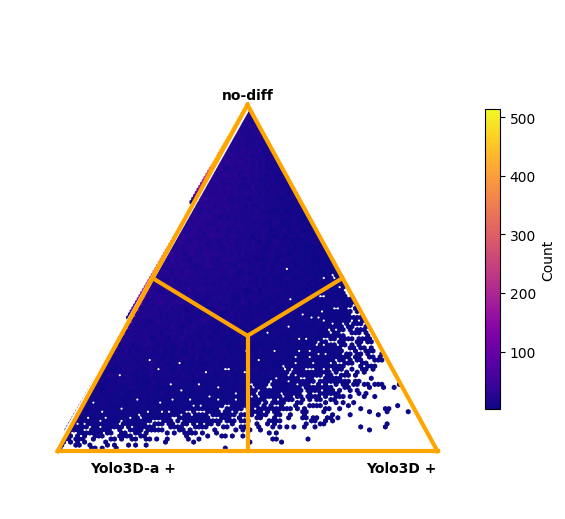

In [170]:
sign.show("Yolo3D", "Yolo3D-a")